# Installationen, Imports und Laden der Daten

Zunächst müssen alle notwendigen Bibliotheken oder Packages importiert werden.

In [2]:
pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.6 MB/s eta 0:00:00


In [18]:
from openai import OpenAI
import openai

In [4]:
#Bibliotheken
# um Excel-Dateien und dadurch Dataframes verarbeiten zu können
import pandas as pd
# für train und test-split
from sklearn.model_selection import train_test_split
# für Evaluation der Datenannotationen von GPT
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, cohen_kappa_score, matthews_corrcoef

# Visualisierungen
import matplotlib.pyplot as plt
import seaborn as sns

import random
import itertools
import math

from pprint import pprint

Variablen, die durchgehend gebraucht werden

In [ ]:
# Label der Level
labels_level_0 = ['fact', 'competence']
labels_level_1 = ['equipment', 'preparation', 'material', 'miscellaneous', 'instruction', 'knowledge', 'manual technique', 'time', 'amount']

Nun werden die Daten geladen

In [6]:
# meine manuellen Labels
file_path = 'Label_Manuell_final.xlsx'
df = pd.read_excel(file_path)

In [7]:
# Zeilen entfernen, bei denen turn leer/NaN ist
df = df[df['turn'].notna() & df['turn'].str.strip().ne('')]

### Zugriff auf API

Ein Zugriff auf die OpenAI API mit persönlichem API key muss eingerichtet werden.

In [22]:
# API key
with open('api_key.txt', 'r') as file:
  api_key = file.read().strip()

client = OpenAI(api_key=api_key)
# Modell
model="gpt-3.5-turbo"

Nun ein kurzer Test ob die API-Anfrage funktioniert.

In [23]:
response = client.chat.completions.create(
    model=model,
    messages=[{"role": "user", "content": "Hallo Welt"}],
    temperature = 0.0
)

print(response.choices[0].message)

ChatCompletionMessage(content='Hallo! Wie kann ich Ihnen helfen?', refusal=None, role='assistant', function_call=None, tool_calls=None)


# Inter-Rater Reliability

In [24]:
# meine Labels
file_path = 'Label_Manuell_final.xlsx'
df_inter = pd.read_excel(file_path)

# Labels des 2. Annotators
file_path_sec_annotator = 'Label_Luca.xlsx'
df_luca = pd.read_excel(file_path_sec_annotator)

In [25]:
#df_inter['label_0'] = df_inter['label_0'].str.lower()
df_inter['label_1'] = df_inter['label_1'].str.lower()
#df_luca['label_0'] = df_luca['label_0'].str.lower()
df_luca['label_1'] = df_luca['label_1'].str.lower()

In [26]:
true_labels = df_inter['label_1']
pred_labels = df_luca['label_1']

In [27]:
# Leere Liste für die Kappa-Werte pro Kategorie
kappa_per_label = {}

for label in labels_level_1:
  true_bin = [1 if l == label else 0 for l in true_labels]
  pred_bin = [1 if l == label else 0 for l in pred_labels]
  # Cohen's Kappa
  kappa = cohen_kappa_score(true_bin, pred_bin)

  kappa_per_label[label] = kappa

for label, kappa in kappa_per_label.items():
  print(f"Cohen's Kappa {label}: {kappa:.2f}")

Cohen's Kappa equipment: 0.86
Cohen's Kappa preparation: 0.84
Cohen's Kappa material: 0.52
Cohen's Kappa miscellaneous: 0.39
Cohen's Kappa instruction: 0.26
Cohen's Kappa knowledge: 0.58
Cohen's Kappa manual technique: 0.22
Cohen's Kappa time: 0.44
Cohen's Kappa amount: 0.80


# Aufteilung in train- und test-Datensatz der manuellen Labels

In [ ]:
# Anzahl der Label Level 0
label_counts_level_0 = df['label_0'].value_counts()

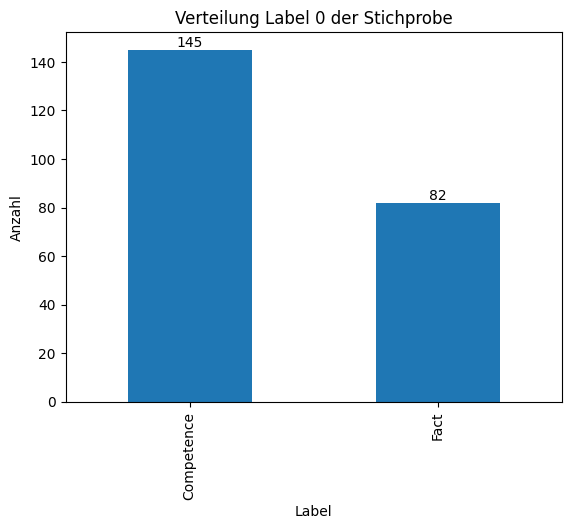

In [ ]:
# Balkendiagramm für Verteilung der Labels
bars = label_counts_level_0.plot(kind='bar')

# Titel und Achsenbeschriftungen
plt.title('Verteilung Label 0 der Stichprobe')
plt.xlabel('Label')
plt.ylabel('Anzahl')
# Häufigkeiten an Balkenkante
for i in bars.containers:
  bars.bar_label(i, label_type='edge')

plt.show()

In [ ]:
# Anzahl der Label Level 1
label_counts_level_1 = df['label_1'].value_counts()

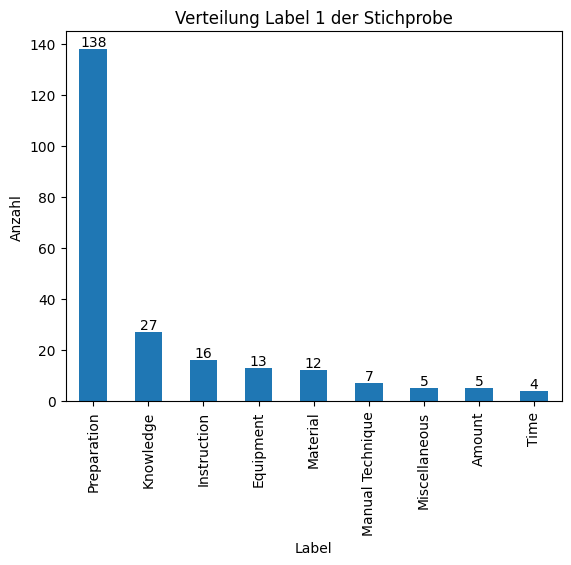

In [ ]:
# Balkendiagramm für Verteilung der Labels LEvel 1
bars = label_counts_level_1.plot(kind='bar')

plt.title('Verteilung Label 1 der Stichprobe')
plt.xlabel('Label')
plt.ylabel('Anzahl')
# Häufigkeiten an Balkenkante
for i in bars.containers:
  bars.bar_label(i, label_type='edge')

plt.show()

In [ ]:
# Konversationen nach ids gruppieren, da die Konversationen nicht aufgeteilt werden sollen, damit Kontext bestehen bleibt
conversations = df.groupby('id_conversation')


In [ ]:
# Seltene Labels (weniger als 10)
labels_rare = label_counts_level_1[label_counts_level_1 < 10].index.tolist()
# Konversationen mit seltenen Labels
conversations_rare = df[df['label_1'].isin(labels_rare)]['id_conversation'].unique()

print(labels_rare)
print(conversations_rare)

['Manual Technique', 'Miscellaneous', 'Amount', 'Time']
[ 2  3  5  6  8  9 10 11 12 13 14]


In [ ]:
# Zuerst werden Konversationen, welche seltene Labels enthalten, auf Train und Test aufgeteilt, damit jeder Dataset die seltenen Labels enthält

# Konversationen mit seltenen Labels
conversations_rare_df = df[df['label_1'].isin(labels_rare)]
conversations_rare = conversations_rare_df['id_conversation'].unique()

# Listen mit Ids der Konv.
train_conversations_rare = []
test_conversations_rare = []

# Durchlaufen der Labels aus labels_rare
for label in labels_rare:
  # Konv.-Ids, welche dieses Label enthalten
  label_conversations = conversations_rare_df[conversations_rare_df['label_1'] == label]['id_conversation'].unique()
  #  Aufteilen auf Train und Test
  train_conv, test_conv = train_test_split(
      label_conversations,
      test_size=0.5,  # 50% Test, 50% Train
      random_state=42
  )
  train_conversations_rare.extend(train_conv)
  test_conversations_rare.extend(test_conv)

print(train_conversations_rare)
print(test_conversations_rare)

[6, 12, 9, 2, 12, 8, 12, 13]
[2, 3, 14, 9, 14, 10, 11, 14, 2, 5]


In [ ]:
# Damit keine Ids sowohl in train als auch test + Set, damit keine doppelten Werte innerhalb
train_conversations_rare = set(train_conversations_rare) - set(test_conversations_rare)
test_conversations_rare = set(test_conversations_rare) - set(train_conversations_rare)
# in Liste konvertieren
train_conversations_rare = list(train_conversations_rare)
test_conversations_rare = list(test_conversations_rare)

print(train_conversations_rare)
print(test_conversations_rare)

[8, 12, 13, 6]
[2, 3, 5, 9, 10, 11, 14]


In [ ]:
# Rest der Konv.-Ids, die eben nicht in conversations_rare sind
conversations_rest = df[~df['id_conversation'].isin(conversations_rare)]['id_conversation'].unique()
print(conversations_rest)

# Aufteilen der restlichen Konversationen (1/3 Training, 2/3 Test, da für few shot nicht viele Beispiele notwendig, für Test sind viele Daten jedoch gut, um gut evaluieren zu können)
train_rest, test_rest = train_test_split(
    conversations_rest,
    test_size=2/3,  # 1/3 in Training, 2/3 in Test
    random_state=42
)

[1 4 7]


In [ ]:
# rest-Datensätze zu rare-Datensätze zufügen
train_conversations = train_conversations_rare + list(train_rest)
test_conversations = test_conversations_rare + list(test_rest)
print(train_conversations)
print(test_conversations)

[8, 12, 13, 6, 7]
[2, 3, 5, 9, 10, 11, 14, 1, 4]


In [ ]:
# dfs final
train_df = df[df['id_conversation'].isin(train_conversations)]
test_df = df[df['id_conversation'].isin(test_conversations)]

# Konv.-Ids pro df
print("train_df:", train_df['id_conversation'].unique())
print("test_df:", test_df['id_conversation'].unique())

train_df: [ 6  7  8 12 13]
test_df: [ 1  2  3  4  5  9 10 11 14]


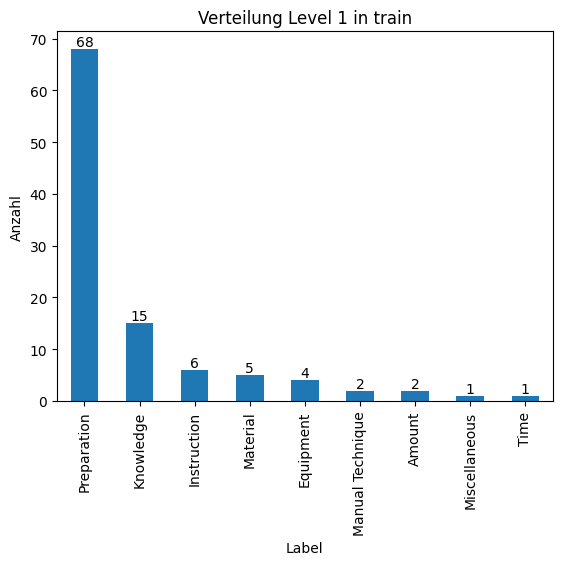

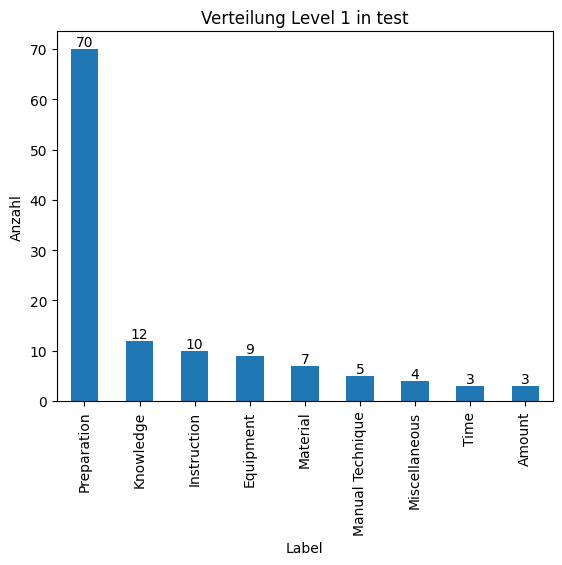

In [ ]:
# train_df
label_counts_train = train_df['label_1'].value_counts()
bars = label_counts_train.plot(kind='bar')

plt.title('Verteilung Level 1 in train')
plt.xlabel('Label')
plt.ylabel('Anzahl')
for i in bars.containers:
  bars.bar_label(i, label_type='edge')

plt.show()


# test_df
label_counts_test = test_df['label_1'].value_counts()
bars = label_counts_test.plot(kind='bar')

plt.title('Verteilung Level 1 in test')
plt.xlabel('Label')
plt.ylabel('Anzahl')
for i in bars.containers:
  bars.bar_label(i, label_type='edge')

plt.show()

In [ ]:
# Export in Excel
train_df.to_excel('train_df.xlsx', index=False)
test_df.to_excel('test_df.xlsx', index=False)

# Methode, um Anfrage an API zu senden und somit Label zu erstellen

In [ ]:
# annotate, um Anfrage an API zu senden und Antwort zu erhalten
# wird bei jedem Prompt aufgerufen

def annotate(client, model, system_content, user_content):
  response = client.chat.completions.create(
      model=model,
      messages=[{"role": "system", "content": system_content}, # prompt
                {"role": "user", "content": user_content}, # turns
      ],
      # Temperatur entscheidet über Kreativität der Antwort:
      # je höher, desto kreativer (+ in dieser Situation ungenauer) -> deswegen niedrig halten für präzise Antwort
      temperature = 0.0)

  result = response.choices[0].message.content
  return result

# **Datenannotation mit GPT-3**

In [ ]:
model = "gpt-3.5-turbo"

In [ ]:
# turns und roles in Liste speichern, damit über diese iteriert werden kann
# wird bei jedem Prompt benötigt
turns = test_df['turn'].tolist()
roles = test_df['role'].tolist()

In [ ]:
# Nur Zeilen von role=student, da generated_label dazu und dann Vergleich; komplett mit teacher passen Längen nicht
test_df_st = test_df[test_df['role'] == 'student']

In [ ]:
test_df_st = test_df_st.copy()

In [ ]:
test_df_st['label_0'] = test_df_st['label_0'].str.lower()
test_df_st['label_1'] = test_df_st['label_1'].str.lower()

In [ ]:
reset_test_df_st = test_df_st.copy()

In [ ]:
true_labels_level_0 = test_df_st['label_0'] # ist immer gleich bei level 0
true_labels_level_1 = test_df_st['label_1'] # ist immer gleich bei level 1

## ***Zero Shot Prompting***

### Level 0

In [ ]:
# Prompt Zero Level 0
prompt_zero_level_0 = """
### CONTEXT ###
The data collected consists of conversations between a conversational assistant ('role'='teacher'), who provides guidance during a do-it-yourself project, and a user ('role'='student'), who expresses statements or questions to the conversational assistant during the process.
In order to find out which information needs the users express with this utterance (also called turn), these must be assigned to their information needs with the help of the taxonomy, i.e. annotated or classified.


### OBJECTIVE ###
Classify/annotate each statement of the user with one of the following two labels, which represent an information need of the user. You are an expert in data annotation!
Each label is briefly defined for better delimitation.

The two labels are as follows:
- "fact": Information need regarding instructions that convey facts. Subcategories assigned to this:
  > "amount": Information need regarding a quantity or frequency specification.
  > "material": Information need regarding the required consumables.
  > "instruction": Information needs regarding the selection or understanding of a project or guidance in general. Including general questions about the overall process or guidance, without referring to individual steps or detailed actions. This includes questions about the general requirements for completing a project, but without asking about specific materials, equipment or step-by-step instructions.
  > "time": Information need regarding a time specification.
  > "equipment": Information need regarding the required equipment such as devices, machines and tools, but not the technique of how to use them.
  > "knowledge": Information need regarding background information/knowledge about the topic.
  > "miscellaneous": Information need that cannot be assigned to any of the other subcategories/labels.

- "competence": Information need on how to carry out the project. These actions or activities are necessary to carry out the project. Subcategories assigned to this:
  > "preparation": Information need regarding the steps of the process, including questions about the next step or tips that should be followed.
  > "manual technique": Information need regarding a practical instruction or method on how exactly to carry out a step that has not yet been described in detail. It is about the HOW of carrying out a step.

Also consider the context and the user's previous statements!
Also consider the previous statements of the conversational assistant, which can have an influence on the label of the user's information needs!

### STYLE ###
Only use the two categories "fact" or "competence"!


### AUDIENCE ###
The labels are used for analysis by a group of scientists in information science and linguistics.


### RESPONSE ###
Only the individual label "fact" or "competence" for each utterance.
"""

In [ ]:
# Aufruf Methode von oben
# prompt wurde oben definiert

pred_labels_zero_level_0 = []

for turn, role in zip(turns, roles):
  if role == 'student':
    label = annotate(client, model, prompt_zero_level_0, turn)
    if label:
      print(f"Turn: {turn}\nLabel: {label}\n")
      pred_labels_zero_level_0.append(label.lower())
    else:
      pred_labels_zero_level_0.append("Fehler bei Anfrage")
  else:
    # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
    continue

Turn: What are the tools and other things required for starting a bonsai tree?
Label: fact

Turn: I'm ready for the first step now please. 
Label: competence

Turn: I've got an idea of where I want it to grow, what's the next step that I need to take now? 
Label: competence

Turn: How do we prepare the tree? 
Label: competence

Turn: Ok, I have a nice dark green pot, perfect. What should I do now?
Label: competence

Turn: Gotcha.  The tree is all ready for potting now, what's next?
Label: competence

Turn: Ok, I've prepared the tree, wired the branches as asked and followed all direction, what should I do now?
Label: competence

Turn: I've pruned and cleaned the roots, what's next?
Label: competence

Turn: How do I prepare the pot?
Label: competence

Turn: It is dry and clean, what should I do now?
Label: competence

Turn: Okay, the tree's been potted.  What now?
Label: competence

Turn: Thanks for the tips, is there anything else I need to know or do?
Label: fact

Turn: I have some go

In [ ]:
# generierte Labels als neue Spalte zu df
test_df_st['pred_label_zero_level_0'] = pred_labels_zero_level_0

In [ ]:
# Vergleich GPT Labels mit manuellen Labels -> neue Spalte agreement, direkte Übereinstimmung: wahr/falsch
test_df_st['agreement_zero_Level_0'] = test_df_st['label_0'] == test_df_st['pred_label_zero_level_0']

Evaluation mit Precision, Recall, F1-Score, Cohen's Kappa

In [ ]:
# true: manuelle Labels
# pred: generierte Labels von GPT
pred_labels_zero_level_0 = test_df_st['pred_label_zero_level_0']

In [ ]:
# Precision, Recall und F1-Score pro Label
precision = precision_score(true_labels_level_0, pred_labels_zero_level_0, average=None, labels=labels_level_0) # average, damit für jedes Label einzeln; labels_level_0 ganz am Anfang
recall = recall_score(true_labels_level_0, pred_labels_zero_level_0, average=None, labels=labels_level_0)
f1 = f1_score(true_labels_level_0, pred_labels_zero_level_0, average=None, labels=labels_level_0)

In [ ]:
report = classification_report(true_labels_level_0, pred_labels_zero_level_0, labels=labels_level_0)
print(report)
# Macro berücksichtigt Verteilung der Klassen nicht
# Weighted Avg berücksichtigt Verteilung, also dass zB Label mit mehr Beispielen eine höhere Chance haben gewählt zu werden als Label mit wenigen Beispielen


              precision    recall  f1-score   support

        fact       0.86      0.67      0.75        48
  competence       0.81      0.93      0.87        75

    accuracy                           0.83       123
   macro avg       0.84      0.80      0.81       123
weighted avg       0.83      0.83      0.82       123



In [ ]:
# Cohen's Kappa: Inter-Rater Reliability -> berechnet mit ein, dass manche Label nur zufällig gewählt wurden
kappa = cohen_kappa_score(true_labels_level_0, pred_labels_zero_level_0, labels=labels_level_0)
print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 0.63


In [ ]:
test_df_st.to_excel('GPT3_Zero_Level0.xlsx', index=False)

In [ ]:
# wieder Original-Zustand
test_df_st = reset_test_df_st.copy()

### Level 1

In [ ]:
# Prompt für Zero-Shot Level 1
prompt_zero_level_1 = """
### CONTEXT ###
The data collected consists of conversations between a conversational assistant ('role'='teacher'), who provides guidance during a do-it-yourself project, and a user ('role'='student'), who expresses statements or questions to the conversational assistant during the process.
In order to find out which information needs the users express with this utterance (also called turn), these must be assigned to their information needs with the help of the taxonomy, i.e. annotated or classified.


### OBJECTIVE ###
Classify/annotate each statement of the user with one of the following labels, which represent an information need of the user. You are an expert in data annotation!
Each label is briefly defined for better delimitation.

The nine labels are as follows:
- "amount": Information need regarding a quantity or frequency specification.
- "material": Information need regarding the required consumables.
- "preparation": Information need regarding the steps of the process, including questions about the next step or tips that should be followed.
- "manual technique": Information need regarding a practical instruction or method on how exactly to carry out a step that has not yet been described in detail. It is about the HOW of carrying out a step.
- "instruction": Information needs regarding the selection or understanding of a project or guidance in general. Including general questions about the overall process or guidance, without referring to individual steps or detailed actions. This includes questions about the general requirements for completing a project, but without asking about specific materials, equipment or step-by-step instructions.
- "time": Information need regarding a time specification.
- "equipment": Information need regarding the required equipment such as devices, machines and tools, but not the technique of how to use them.
- "knowledge": Information need regarding background information/knowledge about the topic.
- "miscellaneous": Information need that cannot be assigned to any of the other categories/labels.

Also consider the context and the user's previous statements!
Also consider the previous statements of the conversational assistant, which can have an influence on the label of the user's information needs!


### STYLE ###
Only use the above labels.


### AUDIENCE ###
The labels are used for analysis by a group of scientists in information science and linguistics.


### RESPONSE ###
Only the label for each utterance.
"""

In [ ]:
# Aufruf der bereits definierten Methode mit Iteration durch die turns
pred_labels_zero_level_1 = []

for turn, role in zip(turns, roles):
  if role == 'student':
    label = annotate(client, model, prompt_zero_level_1, turn)
    # Falls kein Label generiert werden kann
    if label:
      print(f"Turn: {turn}\nLabel: {label}\n")
      pred_labels_zero_level_1.append(label.lower()) # .lower(), damit alles einheitlich mt manuellen Label
    else:
      pred_labels_zero_level_1.append("Fehler bei Anfrage")
  else:
    # Überspringe turns von teacher
    continue

Turn: What are the tools and other things required for starting a bonsai tree?
Label: equipment

Turn: I'm ready for the first step now please. 
Label: preparation

Turn: I've got an idea of where I want it to grow, what's the next step that I need to take now? 
Label: preparation

Turn: How do we prepare the tree? 
Label: preparation

Turn: Ok, I have a nice dark green pot, perfect. What should I do now?
Label: preparation

Turn: Gotcha.  The tree is all ready for potting now, what's next?
Label: preparation

Turn: Ok, I've prepared the tree, wired the branches as asked and followed all direction, what should I do now?
Label: preparation

Turn: I've pruned and cleaned the roots, what's next?
Label: preparation

Turn: How do I prepare the pot?
Label: manual technique

Turn: It is dry and clean, what should I do now?
Label: preparation

Turn: Okay, the tree's been potted.  What now?
Label: preparation

Turn: Thanks for the tips, is there anything else I need to know or do?
Label: instru

In [ ]:
# von GPT-3 generierte Labels als neue Spalte zu df
test_df_st['pred_label_zero_level_1'] = pred_labels_zero_level_1

In [ ]:
# Vergleich GPT-3 Labels mit manuellen Labels -> neue Spalte agreement, direkte Übereinstimmung
test_df_st['agreement_zero_level_1'] = test_df_st['label_1'] == test_df_st['pred_label_zero_level_1']


Jetzt P, R, F1

In [ ]:
# true sind manuelle und pred die von gpt 3
pred_labels_zero_level_1 = test_df_st['pred_label_zero_level_1']

In [ ]:
# Berechnung Precision, Recall und F1-Score für jedes Label
precision = precision_score(true_labels_level_1, pred_labels_zero_level_1, average=None, labels=labels_level_1) # label_level_1 wurde anfangs definiert
recall = recall_score(true_labels_level_1, pred_labels_zero_level_1, average=None, labels=labels_level_1)
f1 = f1_score(true_labels_level_1, pred_labels_zero_level_1, average=None, labels=labels_level_1)

In [ ]:
# Bericht drucken
report = classification_report(true_labels_level_1, pred_labels_zero_level_1, labels=labels_level_1)
print(report)
# macro berücksichtigt die Verteilung der Klassen nicht
#weighted berückschtigt die Verteilung, also dass zB die Label mit mehr Bsp eine höhere Chance auf richtig haben als zB amount


                  precision    recall  f1-score   support

       equipment       0.75      1.00      0.86         9
     preparation       0.98      0.80      0.88        70
        material       0.50      0.14      0.22         7
   miscellaneous       0.33      0.25      0.29         4
     instruction       0.31      0.80      0.44        10
       knowledge       0.83      0.83      0.83        12
manual technique       0.33      0.20      0.25         5
            time       0.60      1.00      0.75         3
          amount       1.00      1.00      1.00         3

        accuracy                           0.75       123
       macro avg       0.63      0.67      0.61       123
    weighted avg       0.81      0.75      0.76       123



In [ ]:
# Berechnung von Cohen's Kappa
kappa = cohen_kappa_score(true_labels_level_1, pred_labels_zero_level_1, labels=labels_level_1)
print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 0.64


In [ ]:
test_df_st.to_excel('GPT3_Zero_Level1.xlsx', index=False)

In [ ]:
test_df_st = reset_test_df_st.copy()

## ***Few Shot Prompting***

In [ ]:
# Für Beispielauswahl
train_df = train_df.copy()

In [ ]:
# Nur Zeilen, bei denen label_0/label_1 Eintrag
train_df = train_df[(train_df['label_0'].notna()) & (train_df['label_0'].str.strip() != '')]

In [ ]:
# Nur Zeilen von role=student
train_df_st = train_df[train_df['role'] == 'student']

In [ ]:
train_df_st = train_df_st.copy()
train_df_st['label_0'] = train_df_st['label_0'].str.lower()
train_df_st['label_1'] = train_df_st['label_1'].str.lower()

### Level 0

In [ ]:
# Prompt für few shot level 0
prompt_few_level_0 = """
### CONTEXT ###
The data collected consists of conversations between a conversational assistant ('role'='teacher'), who provides guidance during a do-it-yourself project, and a user ('role'='student'), who expresses statements or questions to the conversational assistant during the process.
In order to find out which information needs the users express with this utterance (also called turn), these must be assigned to their information needs with the help of the taxonomy, i.e. annotated or classified.


### OBJECTIVE ###
Classify/annotate each statement of the user with one of the following two labels, which represent an information need of the user. You are an expert in data annotation!
Each label is briefly defined for better delimitation.

The two labels are as follows:
- "fact": Information need regarding instructions that convey facts. Subcategories assigned to this:
  > "amount": Information need regarding a quantity or frequency specification.
  > "material": Information need regarding the required consumables.
  > "instruction": Information needs regarding the selection or understanding of a project or guidance in general. Including general questions about the overall process or guidance, without referring to individual steps or detailed actions. This includes questions about the general requirements for completing a project, but without asking about specific materials, equipment or step-by-step instructions.
  > "time": Information need regarding a time specification.
  > "equipment": Information need regarding the required equipment such as devices, machines and tools, but not the technique of how to use them.
  > "knowledge": Information need regarding background information/knowledge about the topic.
  > "miscellaneous": Information need that cannot be assigned to any of the other subcategories/labels.

- "competence": Information need on how to carry out the project. These actions or activities are necessary to carry out the project. Subcategories assigned to this:
  > "preparation": Information need regarding the steps of the process, including questions about the next step or tips that should be followed.
  > "manual technique": Information need regarding a practical instruction or method on how exactly to carry out a step that has not yet been described in detail. It is about the HOW of carrying out a step.

Also consider the context and the user's previous statements!
Also consider the previous statements of the conversational assistant, which can have an influence on the label of the user's information needs!


### STYLE ###
Only use the two categories "fact" or "competence"!


### AUDIENCE ###
The labels are used for analysis by a group of scientists in information science and linguistics.


### RESPONSE ###
Only the individual label "fact" or "competence" for each utterance.


### EXAMPLES ###
{few_shot_examples_level_0}
"""

Auswahl der Few-Shot-Beispiele

In [ ]:
def few_shots(df, label, max):
  label_df = train_df_st[train_df_st['label_0'] == label]
  label_examples = len(label_df)

  if label_examples <= max:
    k = label_examples
  else:
    k = max

  return label_df.sample(n=k, random_state=42)

examples = {}
example_counts = {}  # Um Anzahl der few shots zu speichern

# für jedes Label few shots erstellen + Anzahl
for label in labels_level_0:
  few_examples = few_shots(train_df_st, label, 6)
  examples[label] = few_examples
  example_counts[label] = len(few_examples)

few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label, df in examples.items() for _, row in df.iterrows()])

print(few_shot_examples)

 What tools do I need to build a worm compost system?
 fact
 There are different types of worms, can you tell what the types are and what they are good for? 
 fact
 Doesn't the change in color to brown mean that the pods are dying or unhealthy?
 fact
 I am confused by your response. Would you please rephrase? 
 fact
 Can you tell me what a vacuum thermoflask is used for?
 fact
 How often do I need to feed the worms to feed them "regularly"?
 fact
 I have scrubbed as much as will come off, what is the next step I should take?
 competence
 Alright I got my tools, what now?
 competence
 Is there anything else that I need to do?
 competence
 I've let the clothes hang to dry, what should I do next? 
 competence
 So after they turn brown and I've left some stem on the pods, what is after that?
 competence
 I've take care of that, what can I do next? 
 competence


In [ ]:
for label, count in example_counts.items():
  print(f"Label: {label}: {count}")

Label: fact: 6
Label: competence: 6


In [ ]:
# Platzhalter wird durch few shots ersetzt
prompt_few_level_0 = prompt_few_level_0.replace("{few_shot_examples}", few_shot_examples)

In [ ]:
pred_labels_few_level_0 = []

for turn, role in zip(turns, roles):
  if role == 'student':
    label = annotate(client, model, prompt_few_level_0, turn)
    if label:
      print(f"Turn: {turn}\nLabel: {label}\n")
      pred_labels_few_level_0.append(label.lower())
    else:
      pred_labels_few_level_0.append("Fehler bei Anfrage")
  else:
      # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
      continue

Turn: What are the tools and other things required for starting a bonsai tree?
Label: fact

Turn: I'm ready for the first step now please. 
Label: competence

Turn: I've got an idea of where I want it to grow, what's the next step that I need to take now? 
Label: competence

Turn: How do we prepare the tree? 
Label: competence

Turn: Ok, I have a nice dark green pot, perfect. What should I do now?
Label: competence

Turn: Gotcha.  The tree is all ready for potting now, what's next?
Label: competence

Turn: Ok, I've prepared the tree, wired the branches as asked and followed all direction, what should I do now?
Label: competence

Turn: I've pruned and cleaned the roots, what's next?
Label: competence

Turn: How do I prepare the pot?
Label: competence

Turn: It is dry and clean, what should I do now?
Label: competence

Turn: Okay, the tree's been potted.  What now?
Label: competence

Turn: Thanks for the tips, is there anything else I need to know or do?
Label: fact

Turn: I have some go

In [ ]:
# von GPT-3 generierte Labels als neue Spalte zu df hinzufügen
test_df_st['pred_label_few_level_0'] = pred_labels_few_level_0

In [ ]:
# Vergleich GPT Labels mit manuellen Labels -> neue Spalte agreement = direkte Übereinstimmung: wahr/falsch
test_df_st['agreement_few_level_0'] = test_df_st['label_0'] == test_df_st['pred_label_few_level_0']

In [ ]:
# Labels extrahieren, true sind manuelle und pred die von gpt 3
pred_labels_few_level_0 = test_df_st['pred_label_few_level_0']

In [ ]:
# Berechnung Precision, Recall und F1-Score für jedes Label
precision = precision_score(true_labels_level_0, pred_labels_few_level_0, average=None, labels=labels_level_0)
recall = recall_score(true_labels_level_0, pred_labels_few_level_0, average=None, labels=labels_level_0)
f1 = f1_score(true_labels_level_0, pred_labels_few_level_0, average=None, labels=labels_level_0)

In [ ]:
report = classification_report(true_labels_level_0, pred_labels_few_level_0, labels=labels_level_0)
print(report)

              precision    recall  f1-score   support

        fact       0.84      0.90      0.87        48
  competence       0.93      0.89      0.91        75

    accuracy                           0.89       123
   macro avg       0.89      0.89      0.89       123
weighted avg       0.90      0.89      0.89       123



In [ ]:
# Berechnung Cohen's Kappa
kappa = cohen_kappa_score(true_labels_level_0, pred_labels_few_level_0, labels=labels_level_0)
print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 0.78


In [ ]:
test_df_st.to_excel('GPT3_Few_Level0.xlsx', index=False)
test_df_st = reset_test_df_st.copy()

#### Ändern der Reihenfolge

Nun wird getestet, ob die Reihenfolge der few shots einen Einfluss auf die Performance des Modells hat. Da die eigentliche Anzahl an Permutationen zu groß wäre, wenn jedes Few-Shot Beispiel einzeln betrachtet werden würde (benötigte Rechenleistung zu hoch, wenn alle Möglichkeiten der Reihenfolgen getestet werden würden), wird nur die Reihenfolge der beiden Kategorien als Ganzes getestet.

In [ ]:
list_few_shots = list(examples.keys())

# Anzahl aller möglichen Permutationen
num_labels_level_0 = len(labels_level_0)
num_permut = math.factorial(num_labels_level_0)
print(f"Anzahl möglicher Permutationen: {num_permut}")

permut_few_shots = list(itertools.permutations(list_few_shots))
print(f"Anzahl zu testende Permutationen: {len(permut_few_shots)}")

Anzahl möglicher Permutationen: 2
Anzahl zu testende Permutationen: 2


In [ ]:
def metrics(true_labels, pred_labels):
  precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
  recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
  f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
  return precision, recall, f1

results_permut_few_shots = []

for permut in permut_few_shots:
  # few shot Beispiele pro Permutation
  permuted_few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label in permut for _, row in examples[label].iterrows()])
  # few shot Beispiele im Prompt aktualisieren
  current_prompt = prompt_few_level_0.replace("{few_shot_examples}", permuted_few_shot_examples)
  # nun wieder normaler Ablauf der Annotation
  pred_labels_few_level_0 = []

  for turn, role in zip(turns, roles):
    if role == 'student':
      label = annotate(client, model, current_prompt, turn)
      if label:
        pred_labels_few_level_0.append(label.lower())
      else:
        pred_labels_few_level_0.append("Fehler bei Anfrage")

    else:
      # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
      continue

  # Precision, Recall und F1 pro Permutationen, damit Performance vergleichbar
  p, r, f1 = metrics(true_labels_level_0, pred_labels_few_level_0)

  # Ergebnisse speichern
  results_permut_few_shots.append({'permutation': permut, 'precision': p, 'recall': r, 'f1_score': f1})

# Performance-Ergebnisse der verschiedenen Reihenfolgen
results_permut_few_shots_df = pd.DataFrame(results_permut_few_shots)

precision_mean = results_permut_few_shots_df['precision'].mean()
recall_mean = results_permut_few_shots_df['recall'].mean()
f1_mean = results_permut_few_shots_df['f1_score'].mean()
# um zu sehen wie stark das Modell zwischen Permutationen schwankt
precision_std = results_permut_few_shots_df['precision'].std()
recall_std_ = results_permut_few_shots_df['recall'].std()
f1_std = results_permut_few_shots_df['f1_score'].std()

print(f"Durchschnitt Precision: {precision_mean:.3f} ± {precision_std:.3f}")
print(f"Durchschnitt Recall: {recall_mean:.3f} ± {recall_std_:.3f}")
print(f"Durchschnitt F1-Score: {f1_mean:.3f} ± {f1_std:.3f}")

Durchschnitt Precision: 0.908 ± 0.006
Durchschnitt Recall: 0.907 ± 0.006
Durchschnitt F1-Score: 0.907 ± 0.006


In [ ]:
# Permutation mit bestem f1
best_permutation = results_permut_few_shots_df.loc[results_permut_few_shots_df['f1_score'].idxmax()]
print("Beste Reihenfolge:", best_permutation['permutation'])
print(f"Precision: {best_permutation['precision']:.3f}, Recall: {best_permutation['recall']:.3f}, F1-Score: {best_permutation['f1_score']:.3f}")


Beste Reihenfolge: ('competence', 'fact')
Precision: 0.913, Recall: 0.911, F1-Score: 0.911


In [ ]:
best_order_label = best_permutation['permutation']

# few shots in dieser Reihenfolge
best_order_few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label in best_order_label for _, row in examples[label].iterrows()])

# few shots in Prompt einsetzen
final_prompt = prompt_few_level_0.replace("{few_shot_examples}", best_order_few_shot_examples)

# jetzt wieder Annotation
final_pred_labels_few_level_0 = []

for turn, role in zip(turns, roles):
  if role == 'student':
    label = annotate(client, model, final_prompt, turn)
    if label:
      print(f"Turn: {turn}\nLabel: {label}\n")
      final_pred_labels_few_level_0.append(label.lower())
    else:
      final_pred_labels_few_level_0.append("Fehler bei Anfrage")
  else:
       # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
      continue

Turn: What are the tools and other things required for starting a bonsai tree?
Label: fact

Turn: I'm ready for the first step now please. 
Label: competence

Turn: I've got an idea of where I want it to grow, what's the next step that I need to take now? 
Label: competence

Turn: How do we prepare the tree? 
Label: competence

Turn: Ok, I have a nice dark green pot, perfect. What should I do now?
Label: competence

Turn: Gotcha.  The tree is all ready for potting now, what's next?
Label: competence

Turn: Ok, I've prepared the tree, wired the branches as asked and followed all direction, what should I do now?
Label: competence

Turn: I've pruned and cleaned the roots, what's next?
Label: competence

Turn: How do I prepare the pot?
Label: competence

Turn: It is dry and clean, what should I do now?
Label: competence

Turn: Okay, the tree's been potted.  What now?
Label: competence

Turn: Thanks for the tips, is there anything else I need to know or do?
Label: fact

Turn: I have some go

In [ ]:
# von GPT-3 generierte Labels als neue Spalte zu df hinzufügen
test_df_st['final_pred_labels_few_level_0'] = final_pred_labels_few_level_0

In [ ]:
# Vergleich GPT Labels mit manuellen Labels -> neue Spalte agreement, direkte Übereinstimmung: wahr/falsch
test_df_st['agreement_few_level_0'] = test_df_st['label_0'] == test_df_st['final_pred_labels_few_level_0']

In [ ]:
# Labels extrahieren, true sind manuelle und pred die von gpt 3
# true_labels_level_0 wurde schon definiert
pred_labels_few_level_0 = test_df_st['final_pred_labels_few_level_0']

In [ ]:
# Berechnung Precision, Recall und F1-Score für jedes Label
precision = precision_score(true_labels_level_0, pred_labels_few_level_0, average=None, labels=labels_level_0)
recall = recall_score(true_labels_level_0, pred_labels_few_level_0, average=None, labels=labels_level_0)
f1 = f1_score(true_labels_level_0, pred_labels_few_level_0, average=None, labels=labels_level_0)

In [ ]:
report = classification_report(true_labels_level_0, pred_labels_few_level_0, labels=labels_level_0)
print(report)

              precision    recall  f1-score   support

        fact       0.86      0.92      0.89        48
  competence       0.94      0.91      0.93        75

    accuracy                           0.91       123
   macro avg       0.90      0.91      0.91       123
weighted avg       0.91      0.91      0.91       123



In [ ]:
# Berechnung Cohen's Kappa
kappa = cohen_kappa_score(true_labels_level_0, pred_labels_few_level_0, labels=labels_level_0)
print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 0.81


In [ ]:
test_df_st.to_excel('GPT3_Few_Level0.xlsx', index=False)

In [ ]:
test_df_st = reset_test_df_st.copy()

### Level 1

In [ ]:
# Prompt für Few Shot Level 1
prompt_few_level_1 = """
### CONTEXT ###
The data collected consists of conversations between a conversational assistant ('role'='teacher'), who provides guidance during a do-it-yourself project, and a user ('role'='student'), who expresses statements or questions to the conversational assistant during the process.
In order to find out which information needs the users express with this utterance (also called turn), these must be assigned to their information needs with the help of the taxonomy, i.e. annotated or classified.


### OBJECTIVE ###
Classify/annotate each statement of the user with one of the following labels, which represent an information need of the user. You are an expert in data annotation!
Each label is briefly defined for better delimitation.

The nine labels are as follows:
- "amount": Information need regarding a quantity or frequency specification.
- "material": Information need regarding the required consumables.
- "preparation": Information need regarding the steps of the process, including questions about the next step or tips that should be followed.
- "manual technique": Information need regarding a practical instruction or method on how exactly to carry out a step that has not yet been described in detail. It is about the HOW of carrying out a step.
- "instruction": Information needs regarding the selection or understanding of a project or guidance in general. Including general questions about the overall process or guidance, without referring to individual steps or detailed actions. This includes questions about the general requirements for completing a project, but without asking about specific materials, equipment or step-by-step instructions.
- "time": Information need regarding a time specification.
- "equipment": Information need regarding the required equipment such as devices, machines and tools, but not the technique of how to use them.
- "knowledge": Information need regarding background information/knowledge about the topic.
- "miscellaneous": Information need that cannot be assigned to any of the other categories/labels.

Also consider the context and the user's previous statements!
Also consider the previous statements of the conversational assistant, which can have an influence on the label of the user's information needs!


### STYLE ###
Only use the above labels.


### AUDIENCE ###
The labels are used for analysis by a group of scientists in information science and linguistics.


### RESPONSE ###
Only the label for each utterance.


### EXAMPLES ###
{few_shot_examples}
"""

Auswahl der Few-Shot-Beispiele

In [ ]:
def few_shots(df, label, max):
  label_df = train_df_st[train_df_st['label_1'] == label]
  label_examples = len(label_df)

  if label_examples <= max:
    return label_df  # alle
  #elif label_examples <= 6:
    # k = 4  #  5 war auch gut
  #elif label_examples <= 15:
    # k = 10  #  5 war auch gut
  else:
    k = min(label_examples, max)

  return label_df.sample(n=k, random_state=42)

examples = {}
example_counts = {}  # Um Anzahl der few shots zu speichern

# für jedes Label few shots erstellen + Anzahl
for label in labels_level_1:
  few_examples = few_shots(train_df_st, label, 4)
  examples[label] = few_examples
  example_counts[label] = len(few_examples)

few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label, df in examples.items() for _, row in df.iterrows()])

print(few_shot_examples)

 What tools do I need to build a worm compost system?
 equipment
 What is the best tool to use to harvest the sweet pea seed pods?
 equipment
 Do I need a special container to hold the seeds?
 equipment
 ok, I'm assuming I need rice and a sock, but what other things or tools do I need to make a rice sock?
 equipment
 Alright I will be sure not to overfeed, what‚Äôs my next step?
 preparation
 Now the fizzing in the flask has stopped, what should I do?
 preparation
 I've let the clothes hang to dry, what should I do next? 
 preparation
 Is there anything I should do after taking it to the dry cleaners?
 preparation
 I have added the salt, what materials do I need for the next step?
 material
 What do I need to be feeding it?
 material
 Could I substitute baking soda if I don't have denture cleaning tablets?
 material
 Can I use a shirt that is 50% cotton and 50% wool to test out?
 material
 I am confused by your response. Would you please rephrase? 
 miscellaneous
 I have musty smelling

In [ ]:
for label, count in example_counts.items():
  print(f"Label: {label},  Beispiele: {count}")

Label: equipment,  Beispiele: 4
Label: preparation,  Beispiele: 4
Label: material,  Beispiele: 4
Label: miscellaneous,  Beispiele: 1
Label: instruction,  Beispiele: 4
Label: knowledge,  Beispiele: 4
Label: manual technique,  Beispiele: 2
Label: time,  Beispiele: 1
Label: amount,  Beispiele: 2


In [ ]:
# Platzhalter durch gewählte Beispiele ersetzen
prompt_few_level_1 = prompt_few_level_1.replace("{few_shot_examples}", few_shot_examples)

In [ ]:
pred_labels_few_level_1 = []

for turn, role in zip(turns, roles):
  if role == 'student':
    label = annotate(client, model, prompt_few_level_1, turn)
    if label:
      print(f"Turn: {turn}\nLabel: {label}\n")
      pred_labels_few_level_1.append(label.lower())
    else:
      pred_labels_few_level_1.append("Fehler bei Anfrage")
  else:
      # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
      continue

Turn: What are the tools and other things required for starting a bonsai tree?
Label: equipment

Turn: I'm ready for the first step now please. 
Label: preparation

Turn: I've got an idea of where I want it to grow, what's the next step that I need to take now? 
Label: preparation

Turn: How do we prepare the tree? 
Label: preparation

Turn: Ok, I have a nice dark green pot, perfect. What should I do now?
Label: preparation

Turn: Gotcha.  The tree is all ready for potting now, what's next?
Label: preparation

Turn: Ok, I've prepared the tree, wired the branches as asked and followed all direction, what should I do now?
Label: preparation

Turn: I've pruned and cleaned the roots, what's next?
Label: preparation

Turn: How do I prepare the pot?
Label: preparation

Turn: It is dry and clean, what should I do now?
Label: preparation

Turn: Okay, the tree's been potted.  What now?
Label: preparation

Turn: Thanks for the tips, is there anything else I need to know or do?
Label: instruction

In [ ]:
# von GPT-3 generierte Labels als neue Spalte zu df hinzufügen
test_df_st['pred_label_few_level_1'] = pred_labels_few_level_1

In [ ]:
# Vergleich GPT Labels mit manuellen Labels -> neue Spalte agreement, direkte Übereinstimmung: wahr/falsch
test_df_st['agreement_few_level_1'] = test_df_st['label_1'] == test_df_st['pred_label_few_level_1']

In [ ]:
# Labels extrahieren, true sind manuelle und pred die von gpt 3
pred_labels_few_level_1 = test_df_st['pred_label_few_level_1']

In [ ]:
# Berechnung Precision, Recall und F1-Score für jedes Label
precision = precision_score(true_labels_level_1, pred_labels_few_level_1, average=None, labels=labels_level_1)
recall = recall_score(true_labels_level_1, pred_labels_few_level_1, average=None, labels=labels_level_1)
f1 = f1_score(true_labels_level_1, pred_labels_few_level_1, average=None, labels=labels_level_1)

In [ ]:
# Report
report = classification_report(true_labels_level_1, pred_labels_few_level_1, labels=labels_level_1)
print(report)

                  precision    recall  f1-score   support

       equipment       0.75      1.00      0.86         9
     preparation       0.99      0.94      0.96        70
        material       1.00      0.43      0.60         7
   miscellaneous       0.50      0.50      0.50         4
     instruction       0.50      0.90      0.64        10
       knowledge       0.85      0.92      0.88        12
manual technique       1.00      0.20      0.33         5
            time       1.00      1.00      1.00         3
          amount       1.00      0.67      0.80         3

        accuracy                           0.86       123
       macro avg       0.84      0.73      0.73       123
    weighted avg       0.90      0.86      0.86       123



In [ ]:
# Berechnung Cohen's Kappa
kappa = cohen_kappa_score(true_labels_level_1, pred_labels_few_level_1, labels=labels_level_1)
print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 0.79


In [ ]:
test_df_st.to_excel('GPT3_Few_Level1.xlsx', index=False)
test_df_st = reset_test_df_st.copy()

#### Ändern der Reihenfolge

Nun wird getestet, ob die Reihenfolge der few shots einen Einfluss auf die Performance des Modells hat. Da die eigentliche Anzahl an Permutationen zu groß ist (benötigte Rechenleistung zu hoch), wird nur eine bestimmte Anzahl an verschiedenen Reihenfolgen der few shots getestet und die Beispiele pro Kategorie als Ganzes betrachtet.

In [ ]:
list_few_shots = list(examples.keys())

# Anzahl aller möglichen Permutationen
num_labels_level_1 = len(labels_level_1)
num_permut = math.factorial(num_labels_level_1)
print(f"Anzahl möglicher Permutationen: {num_permut}")

# Da diese Anzahl an Permutationen zu hoch -> Anzahl verringern
permut_few_shots = random.sample(list(itertools.permutations(list_few_shots)), 10)

Anzahl möglicher Permutationen: 362880


In [ ]:
def metrics(true_labels, pred_labels):
  precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
  recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
  f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
  return precision, recall, f1

results_permut_few_shots = []

for permut in permut_few_shots:
  permuted_few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label in permut for _, row in examples[label].iterrows()])
  # few shot Beispiele im Prompt aktualisieren
  current_prompt = prompt_few_level_1.replace("{few_shot_examples}", permuted_few_shot_examples)
  # nun wieder normaler Ablauf der Annotation
  pred_labels_few_level_1 = []

  for turn, role in zip(turns, roles):
    if role == 'student':
      label = annotate(client, model, current_prompt, turn)
      if label:
        pred_labels_few_level_1.append(label.lower())
      else:
        pred_labels_few_level_1.append("Fehler bei Anfrage")
    else:
      # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
      continue

  # Precision, Recall und F1 pro Permutationen, damit Performance vergleichbar
  p, r, f1 = metrics(true_labels_level_1, pred_labels_few_level_1)

  # Ergebnisse speichern
  results_permut_few_shots.append({'permutation': permut, 'precision': p, 'recall': r, 'f1_score': f1})

# Performance-Ergebnisse der verschiedenen Reihenfolgen
results_permut_few_shots_df = pd.DataFrame(results_permut_few_shots)

precision_mean = results_permut_few_shots_df['precision'].mean()
recall_mean = results_permut_few_shots_df['recall'].mean()
f1_mean = results_permut_few_shots_df['f1_score'].mean()

precision_std = results_permut_few_shots_df['precision'].std()
recall_std_ = results_permut_few_shots_df['recall'].std()
f1_std = results_permut_few_shots_df['f1_score'].std()

print(f"Durchschnitt Precision: {precision_mean:.3f} ± {precision_std:.3f}")
print(f"Durchschnitt Recall: {recall_mean:.3f} ± {recall_std_:.3f}")
print(f"Durchschnitt F1-Score: {f1_mean:.3f} ± {f1_std:.3f}")

Durchschnitt Precision: 0.900 ± 0.003
Durchschnitt Recall: 0.861 ± 0.003
Durchschnitt F1-Score: 0.856 ± 0.003


In [ ]:
# Permutation mit bestem f1
best_permutation = results_permut_few_shots_df.loc[results_permut_few_shots_df['f1_score'].idxmax()]
print("Beste Reihenfolge:", best_permutation['permutation'])
print(f"Precision: {best_permutation['precision']:.3f}, Recall: {best_permutation['recall']:.3f}, F1-Score: {best_permutation['f1_score']:.3f}")

Beste Reihenfolge: ('equipment', 'miscellaneous', 'material', 'instruction', 'amount', 'preparation', 'time', 'manual technique', 'knowledge')
Precision: 0.901, Recall: 0.862, F1-Score: 0.857


In [ ]:
best_order_label = best_permutation['permutation']

# few shots
best_order_few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label in best_order_label for _, row in examples[label].iterrows()])

# Platzhalter ersetzen
final_prompt = prompt_few_level_1.replace("{few_shot_examples}", best_order_few_shot_examples)

# jetzt wieder Annotation
final_pred_labels_few_level_1 = []

for turn, role in zip(turns, roles):
  if role == 'student':
    label = annotate(client, model, final_prompt, turn)
    if label:
      print(f"Turn: {turn}\nLabel: {label}\n")
      final_pred_labels_few_level_1.append(label.lower())
    else:
      final_pred_labels_few_level_1.append("Fehler bei Anfrage")
  else:
    # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
    continue

Turn: What are the tools and other things required for starting a bonsai tree?
Label: equipment

Turn: I'm ready for the first step now please. 
Label: preparation

Turn: I've got an idea of where I want it to grow, what's the next step that I need to take now? 
Label: preparation

Turn: How do we prepare the tree? 
Label: preparation

Turn: Ok, I have a nice dark green pot, perfect. What should I do now?
Label: preparation

Turn: Gotcha.  The tree is all ready for potting now, what's next?
Label: preparation

Turn: Ok, I've prepared the tree, wired the branches as asked and followed all direction, what should I do now?
Label: preparation

Turn: I've pruned and cleaned the roots, what's next?
Label: preparation

Turn: How do I prepare the pot?
Label: preparation

Turn: It is dry and clean, what should I do now?
Label: preparation

Turn: Okay, the tree's been potted.  What now?
Label: preparation

Turn: Thanks for the tips, is there anything else I need to know or do?
Label: instruction

In [ ]:
# von GPT-3 generierte Labels als neue Spalte zu df hinzufügen
test_df_st['final_pred_labels_few_level_1'] = final_pred_labels_few_level_1

In [ ]:
# Vergleich GPT Labels mit manuellen Labels -> neue Spalte agreement, direkte Übereinstimmung: wahr/falsch
test_df_st['agreement_few_level_1'] = test_df_st['label_1'] == test_df_st['final_pred_labels_few_level_1']

In [ ]:
# Labels extrahieren, true sind manuelle und pred die von gpt 3
pred_labels_few_level_1 = test_df_st['final_pred_labels_few_level_1']

In [ ]:
# Berechnung Precision, Recall und F1-Score für jedes Label
precision = precision_score(true_labels_level_1, pred_labels_few_level_1, average=None, labels=labels_level_1)
recall = recall_score(true_labels_level_1, pred_labels_few_level_1, average=None, labels=labels_level_1)
f1 = f1_score(true_labels_level_1, pred_labels_few_level_1, average=None, labels=labels_level_1)

In [ ]:
report = classification_report(true_labels_level_1, pred_labels_few_level_1, labels=labels_level_1)
print(report)

                  precision    recall  f1-score   support

       equipment       0.75      1.00      0.86         9
     preparation       0.99      0.94      0.96        70
        material       1.00      0.43      0.60         7
   miscellaneous       0.50      0.50      0.50         4
     instruction       0.50      0.90      0.64        10
       knowledge       0.85      0.92      0.88        12
manual technique       1.00      0.20      0.33         5
            time       1.00      1.00      1.00         3
          amount       1.00      0.67      0.80         3

        accuracy                           0.86       123
       macro avg       0.84      0.73      0.73       123
    weighted avg       0.90      0.86      0.86       123



In [ ]:
# Berechnung Cohen's Kappa
kappa = cohen_kappa_score(true_labels_level_1, pred_labels_few_level_1, labels=labels_level_1)
print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 0.79


In [ ]:
test_df_st.to_excel('GPT3_Few_Level1.xlsx', index=False)
test_df_st = reset_test_df_st.copy()

# **Datenannotation mit GPT-4**

In [ ]:
model = "gpt-4o-mini"

In [ ]:
# turns und roles in Liste speichern, damit über diese iteriert werden kann
# wird bei jedem Prompt benötigt
turns = test_df['turn'].tolist()
roles = test_df['role'].tolist()

In [ ]:
# Nur Zeilen von role=student, da generated_label dazu und dann Vergleich; komplett mit teacher passen Längen nicht
test_df_st = test_df[test_df['role'] == 'student']

In [ ]:
test_df_st = test_df_st.copy()

In [ ]:
test_df_st['label_0'] = test_df_st['label_0'].str.lower()
test_df_st['label_1'] = test_df_st['label_1'].str.lower()

In [ ]:
# um df wieder in orig. Zustand zurückzusetzen
reset_test_df_st = test_df_st.copy()

In [ ]:
true_labels_level_0 = test_df_st['label_0'] # ist immer gleich bei level 0
true_labels_level_1 = test_df_st['label_1'] # ist immer gleich bei level 1

## ***Zero-Shot Prompting***

### Level 0

In [ ]:
# Prompt Zero Level 0
prompt_zero_level_0 = """
### CONTEXT ###
The data collected consists of conversations between a conversational assistant ('role'='teacher'), who provides guidance during a do-it-yourself project, and a user ('role'='student'), who expresses statements or questions to the conversational assistant during the process.
In order to find out which information needs the users express with this utterance (also called turn), these must be assigned to their information needs with the help of the taxonomy, i.e. annotated or classified.


### OBJECTIVE ###
Classify/annotate each statement of the user with one of the following two labels, which represent an information need of the user. You are an expert in data annotation!
Each label is briefly defined for better delimitation.

The two labels are as follows:
- "fact": Information need regarding instructions that convey facts. Subcategories assigned to this:
  > "amount": Information need regarding a quantity or frequency specification.
  > "material": Information need regarding the required consumables.
  > "instruction": Information needs regarding the selection or understanding of a project or guidance in general. Including general questions about the overall process or guidance, without referring to individual steps or detailed actions. This includes questions about the general requirements for completing a project, but without asking about specific materials, equipment or step-by-step instructions.
  > "time": Information need regarding a time specification.
  > "equipment": Information need regarding the required equipment such as devices, machines and tools, but not the technique of how to use them.
  > "knowledge": Information need regarding background information/knowledge about the topic.
  > "miscellaneous": Information need that cannot be assigned to any of the other subcategories/labels.

- "competence": Information need on how to carry out the project. These actions or activities are necessary to carry out the project. Subcategories assigned to this:
  > "preparation": Information need regarding the steps of the process, including questions about the next step or tips that should be followed.
  > "manual technique": Information need regarding a practical instruction or method on how exactly to carry out a step that has not yet been described in detail. It is about the HOW of carrying out a step.

Also consider the context and the user's previous statements!
Also consider the previous statements of the conversational assistant, which can have an influence on the label of the user's information needs!

### STYLE ###
Only use the two categories "fact" or "competence"!


### AUDIENCE ###
The labels are used for analysis by a group of scientists in information science and linguistics.


### RESPONSE ###
Only the individual label "fact" or "competence" for each utterance.
"""

In [ ]:
pred_labels_zero_level_0 = []

for turn, role in zip(turns, roles):
  if role == 'student':
    label = annotate(client, model, prompt_zero_level_0, turn)
    if label:
      print(f"Turn: {turn}\nLabel: {label}\n")
      pred_labels_zero_level_0.append(label.lower())
    else:
      pred_labels_zero_level_0.append("Fehler bei Anfrage")
  else:
    # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
    continue

Turn: What are the tools and other things required for starting a bonsai tree?
Label: fact

Turn: I'm ready for the first step now please. 
Label: competence

Turn: I've got an idea of where I want it to grow, what's the next step that I need to take now? 
Label: competence

Turn: How do we prepare the tree? 
Label: competence

Turn: Ok, I have a nice dark green pot, perfect. What should I do now?
Label: competence

Turn: Gotcha.  The tree is all ready for potting now, what's next?
Label: competence

Turn: Ok, I've prepared the tree, wired the branches as asked and followed all direction, what should I do now?
Label: competence

Turn: I've pruned and cleaned the roots, what's next?
Label: competence

Turn: How do I prepare the pot?
Label: competence

Turn: It is dry and clean, what should I do now?
Label: competence

Turn: Okay, the tree's been potted.  What now?
Label: competence

Turn: Thanks for the tips, is there anything else I need to know or do?
Label: fact

Turn: I have some go

In [ ]:
# generierte Labels als neue Spalte zu df
test_df_st['pred_label_zero_level_0'] = pred_labels_zero_level_0

In [ ]:
# Vergleich GPT Labels mit manuellen Labels -> neue Spalte agreement, direkte Übereinstimmung: wahr/falsch
test_df_st['agreement_zero_Level_0'] = test_df_st['label_0'] == test_df_st['pred_label_zero_level_0']

Evaluation mit Precision, Recall, F1-Score, Cohen's Kappa

In [ ]:
# true: manuelle Labels
# pred: generierte Labels von GPT
pred_labels_zero_level_0 = test_df_st['pred_label_zero_level_0']

In [ ]:
# Precision, Recall und F1-Score pro Label
precision = precision_score(true_labels_level_0, pred_labels_zero_level_0, average=None, labels=labels_level_0) # average, damit für jedes Label einzeln; labels_level_0 ganz am Anfang
recall = recall_score(true_labels_level_0, pred_labels_zero_level_0, average=None, labels=labels_level_0)
f1 = f1_score(true_labels_level_0, pred_labels_zero_level_0, average=None, labels=labels_level_0)

In [ ]:
report = classification_report(true_labels_level_0, pred_labels_zero_level_0, labels=labels_level_0)
print(report)

              precision    recall  f1-score   support

        fact       0.98      0.94      0.96        48
  competence       0.96      0.99      0.97        75

    accuracy                           0.97       123
   macro avg       0.97      0.96      0.97       123
weighted avg       0.97      0.97      0.97       123



In [ ]:
# Cohen's Kappa: Inter-Rater Reliability -> berechnet mit ein, dass manche Label nur zufällig gewählt wurden
kappa = cohen_kappa_score(true_labels_level_0, pred_labels_zero_level_0, labels=labels_level_0)
print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 0.93


In [ ]:
test_df_st.to_excel('GPT4_Zero_Level0.xlsx', index=False)

In [ ]:
test_df_st = reset_test_df_st.copy()

### Level 1

In [ ]:
# Prompt für Zero-Shot Level 1
prompt_zero_level_1 = """
### CONTEXT ###
The data collected consists of conversations between a conversational assistant ('role'='teacher'), who provides guidance during a do-it-yourself project, and a user ('role'='student'), who expresses statements or questions to the conversational assistant during the process.
In order to find out which information needs the users express with this utterance (also called turn), these must be assigned to their information needs with the help of the taxonomy, i.e. annotated or classified.


### OBJECTIVE ###
Classify/annotate each statement of the user with one of the following labels, which represent an information need of the user. You are an expert in data annotation!
Each label is briefly defined for better delimitation.

The nine labels are as follows:
- "amount": Information need regarding a quantity or frequency specification.
- "material": Information need regarding the required consumables.
- "preparation": Information need regarding the steps of the process, including questions about the next step or tips that should be followed.
- "manual technique": Information need regarding a practical instruction or method on how exactly to carry out a step that has not yet been described in detail. It is about the HOW of carrying out a step.
- "instruction": Information needs regarding the selection or understanding of a project or guidance in general. Including general questions about the overall process or guidance, without referring to individual steps or detailed actions. This includes questions about the general requirements for completing a project, but without asking about specific materials, equipment or step-by-step instructions.
- "time": Information need regarding a time specification.
- "equipment": Information need regarding the required equipment such as devices, machines and tools, but not the technique of how to use them.
- "knowledge": Information need regarding background information/knowledge about the topic.
- "miscellaneous": Information need that cannot be assigned to any of the other categories/labels.

Also consider the context and the user's previous statements!


### STYLE ###
Only use the above labels.


### AUDIENCE ###
The labels are used for analysis by a group of scientists in information science and linguistics.


### RESPONSE ###
Only the label for each utterance.
"""

In [ ]:
#print(prompt_zero_level_1)
pred_labels_zero_level_1 = []

for turn, role in zip(turns, roles):
  if role == 'student':
    label = annotate(client, model, prompt_zero_level_1, turn)
    if label:
      print(f"Turn: {turn}\nLabel: {label}\n")
      pred_labels_zero_level_1.append(label.lower()) # .lower(), damit alles einheitlich mt manuellen Label
    # Falls kein Label generiert werden kann
    else:
      pred_labels_zero_level_1.append("Fehler bei Anfrage")
  else:
    # Überspringe turns von teacher
    continue

Turn: What are the tools and other things required for starting a bonsai tree?
Label: equipment

Turn: I'm ready for the first step now please. 
Label: preparation

Turn: I've got an idea of where I want it to grow, what's the next step that I need to take now? 
Label: preparation

Turn: How do we prepare the tree? 
Label: preparation

Turn: Ok, I have a nice dark green pot, perfect. What should I do now?
Label: preparation

Turn: Gotcha.  The tree is all ready for potting now, what's next?
Label: "preparation"

Turn: Ok, I've prepared the tree, wired the branches as asked and followed all direction, what should I do now?
Label: "preparation"

Turn: I've pruned and cleaned the roots, what's next?
Label: "preparation"

Turn: How do I prepare the pot?
Label: "preparation"

Turn: It is dry and clean, what should I do now?
Label: "preparation"

Turn: Okay, the tree's been potted.  What now?
Label: "preparation"

Turn: Thanks for the tips, is there anything else I need to know or do?
Label:

In [ ]:
# "" entfernen, da diese Labels eigentlich richtig
pred_labels_zero_level_1 = [label.strip('"') for label in pred_labels_zero_level_1]

In [ ]:
# neue Spalte mit predicted Labels
test_df_st['pred_label_zero_level_1'] = pred_labels_zero_level_1

In [ ]:
test_df_st['agreement_zero_level_1'] = test_df_st['label_1'] == test_df_st['pred_label_zero_level_1']

Jetzt P, R, F1

In [ ]:
# true sind manuelle und pred die von gpt
pred_labels_zero_level_1 = test_df_st['pred_label_zero_level_1']

In [ ]:
# Berechnung Precision, Recall und F1-Score für jedes Label
precision = precision_score(true_labels_level_1, pred_labels_zero_level_1, average=None, labels=labels_level_1)
recall = recall_score(true_labels_level_1, pred_labels_zero_level_1, average=None, labels=labels_level_1)
f1 = f1_score(true_labels_level_1, pred_labels_zero_level_1, average=None, labels=labels_level_1)

In [ ]:
report = classification_report(true_labels_level_1, pred_labels_zero_level_1, labels=labels_level_1)
print(report)
# macro berücksichtigt die Verteilung der Klassen nicht
#weighted berückschtigt die Verteilung, also dass zB die Label mit mehr Bsp eine höhere Chance auf richtig haben als zB amount

                  precision    recall  f1-score   support

       equipment       1.00      1.00      1.00         9
     preparation       0.97      0.99      0.98        70
        material       0.83      0.71      0.77         7
   miscellaneous       1.00      0.50      0.67         4
     instruction       0.70      0.70      0.70        10
       knowledge       0.71      1.00      0.83        12
manual technique       1.00      0.60      0.75         5
            time       1.00      0.67      0.80         3
          amount       1.00      1.00      1.00         3

        accuracy                           0.91       123
       macro avg       0.91      0.80      0.83       123
    weighted avg       0.92      0.91      0.91       123



In [ ]:
# Berechnung von Cohen's Kappa
kappa = cohen_kappa_score(true_labels_level_1, pred_labels_zero_level_1, labels=labels_level_1)
print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 0.86


In [ ]:
test_df_st.to_excel('GPT4_Zero_Level1.xlsx', index=False)
test_df_st = reset_test_df_st.copy()

## ***Few Shot Prompting***

In [ ]:
# Für Beispielauswahl
train_df = train_df.copy()

In [ ]:
# Nur Zeilen, bei denen label_0 bzw- label_1 Eintrag
train_df = train_df[(train_df['label_0'].notna()) & (train_df['label_0'].str.strip() != '')]

In [ ]:
# Nur Zeilen von role=student
train_df_st = train_df[train_df['role'] == 'student']

In [ ]:
train_df_st = train_df_st.copy()
train_df_st['label_0'] = train_df_st['label_0'].str.lower()
train_df_st['label_1'] = train_df_st['label_1'].str.lower()

In [ ]:
# Prompt für few shot level 0
prompt_few_level_0 = """
### CONTEXT ###
The data collected consists of conversations between a conversational assistant ('role'='teacher'), who provides guidance during a do-it-yourself project, and a user ('role'='student'), who expresses statements or questions to the conversational assistant during the process.
In order to find out which information needs the users express with this utterance (also called turn), these must be assigned to their information needs with the help of the taxonomy, i.e. annotated or classified.


### OBJECTIVE ###
Classify/annotate each statement of the user with one of the following two labels, which represent an information need of the user. You are an expert in data annotation!
Each label is briefly defined for better delimitation.

The two labels are as follows:
- "fact": Information need regarding instructions that convey facts. Subcategories assigned to this:
  > "amount": Information need regarding a quantity or frequency specification.
  > "material": Information need regarding the required consumables.
  > "instruction": Information needs regarding the selection or understanding of a project or guidance in general. Including general questions about the overall process or guidance, without referring to individual steps or detailed actions. This includes questions about the general requirements for completing a project, but without asking about specific materials, equipment or step-by-step instructions.
  > "time": Information need regarding a time specification.
  > "equipment": Information need regarding the required equipment such as devices, machines and tools, but not the technique of how to use them.
  > "knowledge": Information need regarding background information/knowledge about the topic.
  > "miscellaneous": Information need that cannot be assigned to any of the other subcategories/labels.

- "competence": Information need on how to carry out the project. These actions or activities are necessary to carry out the project. Subcategories assigned to this:
  > "preparation": Information need regarding the steps of the process, including questions about the next step or tips that should be followed.
  > "manual technique": Information need regarding a practical instruction or method on how exactly to carry out a step that has not yet been described in detail. It is about the HOW of carrying out a step.

Also consider the context and the user's previous statements!
Also consider the previous statements of the conversational assistant, which can have an influence on the label of the user's information needs!


### STYLE ###
Only use the two categories "fact" or "competence"!


### AUDIENCE ###
The labels are used for analysis by a group of scientists in information science and linguistics.


### RESPONSE ###
Only the individual label "fact" or "competence" for each utterance.


### EXAMPLES ###
{few_shot_examples_level_0}
"""

### Level 0

In [ ]:
# Prompt Zero Level 0
prompt_few_level_0 = """
### CONTEXT ###
The data collected consists of conversations between a conversational assistant ('role'='teacher'), who provides guidance during a do-it-yourself project, and a user ('role'='student'), who expresses statements or questions to the conversational assistant during the process.
In order to find out which information needs the users express with this utterance (also called turn), these must be assigned to their information needs with the help of the taxonomy, i.e. annotated or classified.


### OBJECTIVE ###
Classify/annotate each statement of the user with one of the following two labels, which represent an information need of the user. You are an expert in data annotation!
Each label is briefly defined for better delimitation.

The two labels are as follows:
- "fact": Information need regarding instructions that convey facts. Subcategories assigned to this:
  > "amount": Information need regarding a quantity or frequency specification.
  > "material": Information need regarding the required consumables.
  > "instruction": Information needs regarding the selection or understanding of a project or guidance in general. Including general questions about the overall process or guidance, without referring to individual steps or detailed actions. This includes questions about the general requirements for completing a project, but without asking about specific materials, equipment or step-by-step instructions.
  > "time": Information need regarding a time specification.
  > "equipment": Information need regarding the required equipment such as devices, machines and tools, but not the technique of how to use them.
  > "knowledge": Information need regarding background information/knowledge about the topic.
  > "miscellaneous": Information need that cannot be assigned to any of the other subcategories/labels.

- "competence": Information need on how to carry out the project. These actions or activities are necessary to carry out the project. Subcategories assigned to this:
  > "preparation": Information need regarding the steps of the process, including questions about the next step or tips that should be followed.
  > "manual technique": Information need regarding a practical instruction or method on how exactly to carry out a step that has not yet been described in detail. It is about the HOW of carrying out a step.

Also consider the context and the user's previous statements!
Also consider the previous statements of the conversational assistant, which can have an influence on the label of the user's information needs!

### STYLE ###
Only use the two categories "fact" or "competence"!


### AUDIENCE ###
The labels are used for analysis by a group of scientists in information science and linguistics.


### RESPONSE ###
Only the individual label "fact" or "competence" for each utterance.


### EXAMPLES ###
{few_shot_examples}
"""

#### Auswahl Beispiele

Auswahl der Few-Shot-Beispiele

In [ ]:
def few_shots(df, label, max):
  label_df = train_df_st[train_df_st['label_0'] == label]
  label_examples = len(label_df)

  if label_examples <= max:
    k = label_examples
  else:
    k = max

  return label_df.sample(n=k, random_state=42)

examples = {}
example_counts = {}  # Um Anzahl der few shots zu speichern

# sample 20:  weighted 0.98, cohen 0.94

# für jedes Label few shots erstellen + Anzahl
for label in labels_level_0:
  few_examples = few_shots(train_df_st, label, 20)
  examples[label] = few_examples
  example_counts[label] = len(few_examples)

few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label, df in examples.items() for _, row in df.iterrows()])

print(few_shot_examples)

 What tools do I need to build a worm compost system?
 fact
 There are different types of worms, can you tell what the types are and what they are good for? 
 fact
 Doesn't the change in color to brown mean that the pods are dying or unhealthy?
 fact
 I am confused by your response. Would you please rephrase? 
 fact
 Can you tell me what a vacuum thermoflask is used for?
 fact
 How often do I need to feed the worms to feed them "regularly"?
 fact
 Ok. So the food scraps and the water, is there anything else I need to be aware of to maintain their health?
 fact
 Could I substitute baking soda if I don't have denture cleaning tablets?
 fact
 Will it irritate my skin? I have sensitive skin.
 fact
 How should I clean it?
 fact
 I have musty smelling shirts and pants from my wardrobe, what do I need to go about getting rid of the stink?
 fact
 I guess I'll have to try that then. Are there any other alternatives besides dry-cleaning and similar?
 fact
 Can you specify what the square is refe

In [ ]:
for label, count in example_counts.items():
  print(f"Label: {label}: {count}")

Label: fact: 20
Label: competence: 20


In [ ]:
# Platzhalter füllen
prompt_few_level_0 = prompt_few_level_0.replace("{few_shot_examples}", few_shot_examples)

In [ ]:
pred_labels_few_level_0 = []

for turn, role in zip(turns, roles):
  if role == 'student':
    label = annotate(client, model, prompt_few_level_0, turn)
    if label:
      print(f"Turn: {turn}\nLabel: {label}\n")
      pred_labels_few_level_0.append(label.lower())
    else:
      pred_labels_few_level_0.append("Fehler bei Anfrage")

  else:
    # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
    continue

Turn: What are the tools and other things required for starting a bonsai tree?
Label: fact

Turn: I'm ready for the first step now please. 
Label: competence

Turn: I've got an idea of where I want it to grow, what's the next step that I need to take now? 
Label: competence

Turn: How do we prepare the tree? 
Label: competence

Turn: Ok, I have a nice dark green pot, perfect. What should I do now?
Label: competence

Turn: Gotcha.  The tree is all ready for potting now, what's next?
Label: competence

Turn: Ok, I've prepared the tree, wired the branches as asked and followed all direction, what should I do now?
Label: competence

Turn: I've pruned and cleaned the roots, what's next?
Label: competence

Turn: How do I prepare the pot?
Label: competence

Turn: It is dry and clean, what should I do now?
Label: competence

Turn: Okay, the tree's been potted.  What now?
Label: competence

Turn: Thanks for the tips, is there anything else I need to know or do?
Label: fact

Turn: I have some go

In [ ]:
# generierte Labels als neue Spalte zu df hinzufügen
test_df_st['pred_label_few_level_0'] = pred_labels_few_level_0

In [ ]:
# Vergleich GPT Labels mit manuellen Labels -> neue Spalte agreement, direkte Übereinstimmung: wahr/falsch
test_df_st['agreement_few_level_0'] = test_df_st['label_0'] == test_df_st['pred_label_few_level_0']

In [ ]:
# Labels extrahieren, true sind manuelle und pred die von gpt
pred_labels_few_level_0 = test_df_st['pred_label_few_level_0']

In [ ]:
# Berechnung Precision, Recall und F1-Score für jedes Label
precision = precision_score(true_labels_level_0, pred_labels_few_level_0, average=None, labels=labels_level_0)
recall = recall_score(true_labels_level_0, pred_labels_few_level_0, average=None, labels=labels_level_0)
f1 = f1_score(true_labels_level_0, pred_labels_few_level_0, average=None, labels=labels_level_0)

In [ ]:
report = classification_report(true_labels_level_0, pred_labels_few_level_0, labels=labels_level_0)
print(report)

              precision    recall  f1-score   support

        fact       0.98      0.96      0.97        48
  competence       0.97      0.99      0.98        75

    accuracy                           0.98       123
   macro avg       0.98      0.97      0.97       123
weighted avg       0.98      0.98      0.98       123



In [ ]:
# Berechnung Cohen's Kappa
kappa = cohen_kappa_score(true_labels_level_0, pred_labels_few_level_0, labels=labels_level_0)
print(f"Cohen's Kappa: {kappa:.2f}")


Cohen's Kappa: 0.95


In [ ]:
test_df_st.to_excel('GPT4_Few_Level0.xlsx', index=False)


#### Ändern der Reihenfolge

Nun wird getestet, ob die Reihenfolge der few shots einen Einfluss auf die Performance des Modells hat. Da die eigentliche Anzahl an Permutationen zu groß wäre, wenn jedes Few-Shot Beispiel einzeln betrachtet werden würde (benötigte Rechenleistung zu hoch, wenn alle Möglichkeiten der Reihenfolgen getestet werden würden), wird nur die Reihenfolge der beiden Kategorien als Ganzes getestet.

In [ ]:
list_few_shots = list(examples.keys())

# mögliche Anzahl
num_labels_level_0 = len(labels_level_0)
num_permut = math.factorial(num_labels_level_0)
print(f"Anzahl möglicher Permutationen: {num_permut}")

permut_few_shots = list(itertools.permutations(list_few_shots))

Anzahl möglicher Permutationen: 2


In [ ]:
def metrics(true_labels, pred_labels):
  precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
  recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
  f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
  return precision, recall, f1

results_permut_few_shots = []

for permut in permut_few_shots:
  permuted_few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label in permut for _, row in examples[label].iterrows()])
  # few shot Beispiele im Prompt aktualisieren
  current_prompt = prompt_few_level_0.replace("{few_shot_examples}", permuted_few_shot_examples)
  # nun wieder normaler Ablauf der Annotation
  pred_labels_few_level_0 = []

  for turn, role in zip(turns, roles):
    if role == 'student':
      label = annotate(client, model, current_prompt, turn)
      if label:
        pred_labels_few_level_0.append(label.lower())
      else:
        pred_labels_few_level_0.append("Fehler bei Anfrage")

    else:
      # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
      continue

  # Precision, Recall und F1 pro Permutationen, damit Performance vergleichbar
  p, r, f1 = metrics(true_labels_level_0, pred_labels_few_level_0)

  # Ergebnisse speichern
  results_permut_few_shots.append({'permutation': permut, 'precision': p, 'recall': r, 'f1_score': f1})

# Performance-Ergebnisse der verschiedenen Reihenfolgen
results_permut_few_shots_df = pd.DataFrame(results_permut_few_shots)

precision_mean = results_permut_few_shots_df['precision'].mean()
recall_mean = results_permut_few_shots_df['recall'].mean()
f1_mean = results_permut_few_shots_df['f1_score'].mean()

precision_std = results_permut_few_shots_df['precision'].std()
recall_std_ = results_permut_few_shots_df['recall'].std()
f1_std = results_permut_few_shots_df['f1_score'].std()

print(f"Durchschnitt Precision: {precision_mean:.3f} ± {precision_std:.3f}")
print(f"Durchschnitt Recall: {recall_mean:.3f} ± {recall_std_:.3f}")
print(f"Durchschnitt F1-Score: {f1_mean:.3f} ± {f1_std:.3f}")

Durchschnitt Precision: 0.972 ± 0.006
Durchschnitt Recall: 0.972 ± 0.006
Durchschnitt F1-Score: 0.971 ± 0.006


In [ ]:
# Permutation mit bestem f1
best_permutation = results_permut_few_shots_df.loc[results_permut_few_shots_df['f1_score'].idxmax()]
#print("Beste Reihenfolge:", best_permutation['permutation'])
#print(f"Precision: {best_permutation['precision']:.3f}, Recall: {best_permutation['recall']:.3f}, F1-Score: {best_permutation['f1_score']:.3f}")

In [ ]:
best_order_label = best_permutation['permutation']

best_order_few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label in best_order_label for _, row in examples[label].iterrows()])

# Platzhalter durch few shots ersetzen
final_prompt = prompt_few_level_0.replace("{few_shot_examples}", best_order_few_shot_examples)

final_pred_labels_few_level_0 = []

for turn, role in zip(turns, roles):
  if role == 'student':
    label = annotate(client, model, final_prompt, turn)
    if label:
      print(f"Turn: {turn}\nLabel: {label}\n")
      final_pred_labels_few_level_0.append(label.lower())
    else:
      final_pred_labels_few_level_0.append("Fehler bei Anfrage")
  else:
    # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
    continue

Turn: What are the tools and other things required for starting a bonsai tree?
Label: fact

Turn: I'm ready for the first step now please. 
Label: competence

Turn: I've got an idea of where I want it to grow, what's the next step that I need to take now? 
Label: competence

Turn: How do we prepare the tree? 
Label: competence

Turn: Ok, I have a nice dark green pot, perfect. What should I do now?
Label: competence

Turn: Gotcha.  The tree is all ready for potting now, what's next?
Label: competence

Turn: Ok, I've prepared the tree, wired the branches as asked and followed all direction, what should I do now?
Label: competence

Turn: I've pruned and cleaned the roots, what's next?
Label: competence

Turn: How do I prepare the pot?
Label: competence

Turn: It is dry and clean, what should I do now?
Label: competence

Turn: Okay, the tree's been potted.  What now?
Label: competence

Turn: Thanks for the tips, is there anything else I need to know or do?
Label: fact

Turn: I have some go

In [ ]:
# generierte Labels als neue Spalte zu df hinzufügen
test_df_st['final_pred_labels_few_level_0'] = final_pred_labels_few_level_0

In [ ]:
# Vergleich GPT Labels mit manuellen Labels -> neue Spalte agreement, direkte Übereinstimmung: wahr/falsch
test_df_st['agreement_few_level_0'] = test_df_st['label_0'] == test_df_st['final_pred_labels_few_level_0']

In [ ]:
# Labels extrahieren, true sind manuelle und pred die von gpt
pred_labels_few_level_0 = test_df_st['final_pred_labels_few_level_0']

In [ ]:
# Berechnung Precision, Recall und F1-Score für jedes Label
precision = precision_score(true_labels_level_0, pred_labels_few_level_0, average=None, labels=labels_level_0)
recall = recall_score(true_labels_level_0, pred_labels_few_level_0, average=None, labels=labels_level_0)
f1 = f1_score(true_labels_level_0, pred_labels_few_level_0, average=None, labels=labels_level_0)

In [ ]:
report = classification_report(true_labels_level_0, pred_labels_few_level_0, labels=labels_level_0)
print(report)

              precision    recall  f1-score   support

        fact       0.98      0.96      0.97        48
  competence       0.97      0.99      0.98        75

    accuracy                           0.98       123
   macro avg       0.98      0.97      0.97       123
weighted avg       0.98      0.98      0.98       123



In [ ]:
# Berechnung Cohen's Kappa
kappa = cohen_kappa_score(true_labels_level_0, pred_labels_few_level_0, labels=labels_level_0)
print("Cohen's Kappa:", kappa)

# Berechnung Matthews Correlation Coefficient?!
mcc = matthews_corrcoef(true_labels_level_0, pred_labels_few_level_0)
print("Matthews Correlation Coefficient:", mcc)

Cohen's Kappa: 0.9485570890840652
Matthews Correlation Coefficient: 0.9486965773990359


### Level 1

In [ ]:
#test_df_st = reset_test_df_st.copy()

In [ ]:
# Prompt für Few Shot Level 1
prompt_few_level_1 = """
### CONTEXT ###
The data collected consists of conversations between a conversational assistant ('role'='teacher'), who provides guidance during a do-it-yourself project, and a user ('role'='student'), who expresses statements or questions to the conversational assistant during the process.
In order to find out which information needs the users express with this utterance (also called turn), these must be assigned to their information needs with the help of the taxonomy, i.e. annotated or classified.


### OBJECTIVE ###
Classify/annotate each statement of the user with one of the following labels, which represent an information need of the user. You are an expert in data annotation!
Each label is briefly defined for better delimitation.

The nine labels are as follows:
- "amount": Information need regarding a quantity or frequency specification.
- "material": Information need regarding the required consumables.
- "preparation": Information need regarding the steps of the process, including questions about the next step or tips that should be followed.
- "manual technique": Information need regarding a practical instruction or method on how exactly to carry out a step that has not yet been described in detail. It is about the HOW of carrying out a step.
- "instruction": Information needs regarding the selection or understanding of a project or guidance in general. Including general questions about the overall process or guidance, without referring to individual steps or detailed actions. This includes questions about the general requirements for completing a project, but without asking about specific materials, equipment or step-by-step instructions.
- "time": Information need regarding a time specification.
- "equipment": Information need regarding the required equipment such as devices, machines and tools, but not the technique of how to use them.
- "knowledge": Information need regarding background information/knowledge about the topic.
- "miscellaneous": Information need that cannot be assigned to any of the other categories/labels.

Also consider the context and the user's previous statements!
Also consider the previous statements of the conversational assistant, which can have an influence on the label of the user's information needs!


### STYLE ###
Only use the above labels.


### AUDIENCE ###
The labels are used for analysis by a group of scientists in information science and linguistics.


### RESPONSE ###
Only the label for each utterance.


### EXAMPLES ###
{few_shot_examples}
"""

#### Auswahl Beispiele

Auswahl der Few-Shot-Beispiele

In [ ]:
# wenn k festen Wert
# 8 und sample 1: weighted 0.93, coehn 0.8997, man tech 0.75
# 8 und sample 2: weighted 0.93, coehn 0.88
# 8 und sample 3: weighted 0.93, coehn 0.88
# 8 und sample 4: weighted 0.93, coehn 0.89
# 8 und sample 5: weighted 0.93, cohen 0.88
# 8 und sample 6: weighted avg 0.93, cohen 0.88
# 8 und sample 7: weighted avg 0.93 gleich
# 8 und sample 8: weighted avg 0.92, 0.87
# 8 und sample 9: weighted avg 0.93, 0.88
# 8 und sample 10: weighted avg 0.93 gleich
# 8 und sample 12: weighted avg gleich
# 8 und sample 14: weighted avg gleich
# 8 und sample 20: weighted avg gleich

# wenn k verschieden
# gleiches Ergebnis wie <2=alle, <=6=3, <=15=7 und max
  # if label_examples <= 10:
      #return label_df  # Alle
  # else:
      #k = min(label_examples, max)

In [ ]:
def few_shots(df, label, max):
  label_df = train_df_st[train_df_st['label_1'] == label]
  label_examples = len(label_df)

  if label_examples <= max:
    return label_df  # alle
  #elif label_examples <= 6:
    # k = 4  #  5 war gut
  #elif label_examples <= 15:
    # k = 10  #  5 war gut
  else:
    k = min(label_examples, max)

  return label_df.sample(n=k, random_state=42)

examples = {}
example_counts = {}  # Um Anzahl der few shots zu speichern

# für jedes Label few shots erstellen + Anzahl
for label in labels_level_1:
  few_examples = few_shots(train_df_st, label, 4)
  examples[label] = few_examples
  example_counts[label] = len(few_examples)

few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label, df in examples.items() for _, row in df.iterrows()])

print(few_shot_examples)

 What tools do I need to build a worm compost system?
 equipment
 What is the best tool to use to harvest the sweet pea seed pods?
 equipment
 Do I need a special container to hold the seeds?
 equipment
 ok, I'm assuming I need rice and a sock, but what other things or tools do I need to make a rice sock?
 equipment
 Alright I will be sure not to overfeed, what‚Äôs my next step?
 preparation
 Now the fizzing in the flask has stopped, what should I do?
 preparation
 I've let the clothes hang to dry, what should I do next? 
 preparation
 Is there anything I should do after taking it to the dry cleaners?
 preparation
 I have added the salt, what materials do I need for the next step?
 material
 What do I need to be feeding it?
 material
 Could I substitute baking soda if I don't have denture cleaning tablets?
 material
 Can I use a shirt that is 50% cotton and 50% wool to test out?
 material
 I am confused by your response. Would you please rephrase? 
 miscellaneous
 I have musty smelling

In [ ]:
for label, count in example_counts.items():
  print(f"Label: {label}, Anzahl ausgewählter Beispiele: {count}")

Label: equipment, Anzahl ausgewählter Beispiele: 4
Label: preparation, Anzahl ausgewählter Beispiele: 4
Label: material, Anzahl ausgewählter Beispiele: 4
Label: miscellaneous, Anzahl ausgewählter Beispiele: 1
Label: instruction, Anzahl ausgewählter Beispiele: 4
Label: knowledge, Anzahl ausgewählter Beispiele: 4
Label: manual technique, Anzahl ausgewählter Beispiele: 2
Label: time, Anzahl ausgewählter Beispiele: 1
Label: amount, Anzahl ausgewählter Beispiele: 2


In [ ]:
# Platzhalter ersetzen
prompt_few_level_1 = prompt_few_level_1.replace("{few_shot_examples}", few_shot_examples)

In [ ]:
pred_labels_few_level_1 = []

for turn, role in zip(turns, roles):
  if role == 'student':
    label = annotate(client, model, prompt_few_level_1, turn)
    if label:
      print(f"Turn: {turn}\nLabel: {label}\n")
      pred_labels_few_level_1.append(label.lower())
    else:
      pred_labels_few_level_1.append("Fehler bei Anfrage")
  else:
    # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
    continue

Turn: What are the tools and other things required for starting a bonsai tree?
Label: equipment

Turn: I'm ready for the first step now please. 
Label: preparation

Turn: I've got an idea of where I want it to grow, what's the next step that I need to take now? 
Label: preparation

Turn: How do we prepare the tree? 
Label: preparation

Turn: Ok, I have a nice dark green pot, perfect. What should I do now?
Label: preparation

Turn: Gotcha.  The tree is all ready for potting now, what's next?
Label: preparation

Turn: Ok, I've prepared the tree, wired the branches as asked and followed all direction, what should I do now?
Label: preparation

Turn: I've pruned and cleaned the roots, what's next?
Label: preparation

Turn: How do I prepare the pot?
Label: preparation

Turn: It is dry and clean, what should I do now?
Label: preparation

Turn: Okay, the tree's been potted.  What now?
Label: preparation

Turn: Thanks for the tips, is there anything else I need to know or do?
Label: instruction

In [ ]:
# generierte Labels als neue Spalte zu df hinzufügen
test_df_st['pred_label_few_level_1'] = pred_labels_few_level_1

In [ ]:
# Vergleich GPT Labels mit manuellen Labels -> neue Spalte agreement, direkte Übereinstimmung: wahr/falsch
test_df_st['agreement_few_level_1'] = test_df_st['label_1'] == test_df_st['pred_label_few_level_1']

In [ ]:
# Labels extrahieren, true sind manuelle und pred die von gpt
# true_labels_level_1 wurde schon definiert
pred_labels_few_level_1 = test_df_st['pred_label_few_level_1']

In [ ]:
# Berechnung Precision, Recall und F1-Score für jedes Label
precision = precision_score(true_labels_level_1, pred_labels_few_level_1, average=None, labels=labels_level_1)
recall = recall_score(true_labels_level_1, pred_labels_few_level_1, average=None, labels=labels_level_1)
f1 = f1_score(true_labels_level_1, pred_labels_few_level_1, average=None, labels=labels_level_1)

In [ ]:
report = classification_report(true_labels_level_1, pred_labels_few_level_1, labels=labels_level_1)
print(report)

                  precision    recall  f1-score   support

       equipment       1.00      1.00      1.00         9
     preparation       1.00      0.99      0.99        70
        material       1.00      0.86      0.92         7
   miscellaneous       1.00      0.50      0.67         4
     instruction       0.67      0.80      0.73        10
       knowledge       0.75      1.00      0.86        12
manual technique       1.00      0.60      0.75         5
            time       1.00      1.00      1.00         3
          amount       1.00      1.00      1.00         3

        accuracy                           0.93       123
       macro avg       0.94      0.86      0.88       123
    weighted avg       0.95      0.93      0.93       123



In [ ]:
# Berechnung Cohen's Kappa
kappa = cohen_kappa_score(true_labels_level_1, pred_labels_few_level_1, labels=labels_level_1)
print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 0.90


In [ ]:
test_df_st.to_excel('GPT4_Few_Level1.xlsx', index=False)

In [ ]:
test_df_st = reset_test_df_st.copy()

#### Ändern der Reihenfolge

Nun wird getestet, ob die Reihenfolge der few shots einen Einfluss auf die Performance des Modells hat. Da die eigentliche Anzahl an Permutationen zu groß ist (benötigte Rechenleistung zu hoch), wird nur eine bestimmte Anzahl an verschiedenen Reihenfolgen der few shots getestet.

In [ ]:
list_few_shots = list(examples.keys())

# Anzahl aller möglichen Permutationen
num_labels_level_1 = len(labels_level_1)
num_permut = math.factorial(num_labels_level_1)
print(f"Anzahl möglicher Permutationen: {num_permut}")

# Da diese Anzahl an Permutationen zu hoch -> Anzahl verringern
permut_few_shots = random.sample(list(itertools.permutations(list_few_shots)), 10)

Anzahl möglicher Permutationen: 362880


In [ ]:
def metrics(true_labels, pred_labels):
  precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
  recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
  f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
  return precision, recall, f1

results_permut_few_shots = []

for permut in permut_few_shots:
  permuted_few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label in permut for _, row in examples[label].iterrows()])
  # few shot Beispiele im Prompt aktualisieren
  current_prompt = prompt_few_level_1.replace("{few_shot_examples}", permuted_few_shot_examples)
  # nun wieder normaler Ablauf der Annotation
  pred_labels_few_level_1 = []

  for turn, role in zip(turns, roles):
    if role == 'student':
      label = annotate(client, model, current_prompt, turn)
      if label:
        pred_labels_few_level_1.append(label.lower())
      else:
        pred_labels_few_level_1.append("Fehler bei Anfrage")
    else:
      # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
      continue

  # Precision, Recall und F1 pro Permutationen, damit Performance vergleichbar
  p, r, f1 = metrics(true_labels_level_1, pred_labels_few_level_1)

  # Ergebnisse speichern
  results_permut_few_shots.append({'permutation': permut, 'precision': p, 'recall': r, 'f1_score': f1})

# Performance-Ergebnisse der verschiedenen Reihenfolgen
results_permut_few_shots_df = pd.DataFrame(results_permut_few_shots)

precision_mean = results_permut_few_shots_df['precision'].mean()
recall_mean = results_permut_few_shots_df['recall'].mean()
f1_mean = results_permut_few_shots_df['f1_score'].mean()

precision_std = results_permut_few_shots_df['precision'].std()
recall_std_ = results_permut_few_shots_df['recall'].std()
f1_std = results_permut_few_shots_df['f1_score'].std()

print(f"Durchschnitt Precision: {precision_mean:.3f} ± {precision_std:.3f}")
print(f"Durchschnitt Recall: {recall_mean:.3f} ± {recall_std_:.3f}")
print(f"Durchschnitt F1-Score: {f1_mean:.3f} ± {f1_std:.3f}")

Durchschnitt Precision: 0.949 ± 0.000
Durchschnitt Recall: 0.935 ± 0.000
Durchschnitt F1-Score: 0.934 ± 0.000


In [ ]:
# Permutation mit bestem f1
best_permutation = results_permut_few_shots_df.loc[results_permut_few_shots_df['f1_score'].idxmax()]
print("Beste Reihenfolge:", best_permutation['permutation'])
print(f"Precision: {best_permutation['precision']:.3f}, Recall: {best_permutation['recall']:.3f}, F1-Score: {best_permutation['f1_score']:.3f}")

Beste Reihenfolge: ('knowledge', 'time', 'equipment', 'miscellaneous', 'material', 'manual technique', 'instruction', 'preparation', 'amount')
Precision: 0.949, Recall: 0.935, F1-Score: 0.934


In [ ]:
best_order_label = best_permutation['permutation']

best_order_few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label in best_order_label for _, row in examples[label].iterrows()])

# Platzhalter füllen
final_prompt = prompt_few_level_1.replace("{few_shot_examples}", best_order_few_shot_examples)
# jetzt wieder Annotation
final_pred_labels_few_level_1 = []

for turn, role in zip(turns, roles):
  if role == 'student':
    label = annotate(client, model, final_prompt, turn)
    if label:
      print(f"Turn: {turn}\nLabel: {label}\n")
      final_pred_labels_few_level_1.append(label.lower())
    else:
      final_pred_labels_few_level_1.append("Fehler bei Anfrage")
  else:
    # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
    continue

Turn: What are the tools and other things required for starting a bonsai tree?
Label: equipment

Turn: I'm ready for the first step now please. 
Label: preparation

Turn: I've got an idea of where I want it to grow, what's the next step that I need to take now? 
Label: preparation

Turn: How do we prepare the tree? 
Label: preparation

Turn: Ok, I have a nice dark green pot, perfect. What should I do now?
Label: preparation

Turn: Gotcha.  The tree is all ready for potting now, what's next?
Label: preparation

Turn: Ok, I've prepared the tree, wired the branches as asked and followed all direction, what should I do now?
Label: preparation

Turn: I've pruned and cleaned the roots, what's next?
Label: preparation

Turn: How do I prepare the pot?
Label: preparation

Turn: It is dry and clean, what should I do now?
Label: preparation

Turn: Okay, the tree's been potted.  What now?
Label: preparation

Turn: Thanks for the tips, is there anything else I need to know or do?
Label: instruction

In [ ]:
# generierte Labels als neue Spalte zu df hinzufügen
test_df_st['final_pred_labels_few_level_1'] = final_pred_labels_few_level_1

In [ ]:
# Vergleich GPT Labels mit manuellen Labels -> neue Spalte agreement, direkte Übereinstimmung: wahr/falsch
test_df_st['agreement_few_level_1'] = test_df_st['label_1'] == test_df_st['final_pred_labels_few_level_1']

In [ ]:
# Labels extrahieren, true sind manuelle und pred die von gpt
pred_labels_few_level_1 = test_df_st['final_pred_labels_few_level_1']

In [ ]:
# Berechnung Precision, Recall und F1-Score für jedes Label
precision = precision_score(true_labels_level_1, pred_labels_few_level_1, average=None, labels=labels_level_1)
recall = recall_score(true_labels_level_1, pred_labels_few_level_1, average=None, labels=labels_level_1)
f1 = f1_score(true_labels_level_1, pred_labels_few_level_1, average=None, labels=labels_level_1)

In [ ]:
report = classification_report(true_labels_level_1, pred_labels_few_level_1, labels=labels_level_1)
print(report)

                  precision    recall  f1-score   support

       equipment       1.00      1.00      1.00         9
     preparation       1.00      0.99      0.99        70
        material       1.00      0.86      0.92         7
   miscellaneous       1.00      0.50      0.67         4
     instruction       0.67      0.80      0.73        10
       knowledge       0.75      1.00      0.86        12
manual technique       1.00      0.60      0.75         5
            time       1.00      1.00      1.00         3
          amount       1.00      1.00      1.00         3

        accuracy                           0.93       123
       macro avg       0.94      0.86      0.88       123
    weighted avg       0.95      0.93      0.93       123



In [ ]:
# Berechnung Cohen's Kappa
kappa = cohen_kappa_score(true_labels_level_1, pred_labels_few_level_1, labels=labels_level_1)
print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 0.90


In [ ]:
test_df_st.to_excel('GPT4_Few_Level1.xlsx', index=False)

# **Annotation des gesamten Datensatzes**

Zunächst wird der Datensatz noch vorbereitet, damit er verarbeitet werden kann.

In [ ]:
file_path = 'Wizard_of_Tasks.xlsx'
df_wot = pd.read_excel(file_path)

In [ ]:
# Zeilen entfernen, bei denen turn leer ist, da sonst Fehler entstehen können
df_wot = df_wot[df_wot['turn'].notna() & df_wot['turn'].str.strip().ne('')]

In [ ]:
print(df_wot['turn'].value_counts())

turn
Do you have any other questions?                                                                                                         4
I have included information on next step.                                                                                                4
What should I do next?                                                                                                                   3
Oh okay, so what is my next step?                                                                                                        3
What should I do after applying the paste?                                                                                               2
                                                                                                                                        ..
Next you'll learn about starting your seeds inside. I've shared the entire step for you so you'll know what to do next! Check it out.    1
Gotcha!  I started my 

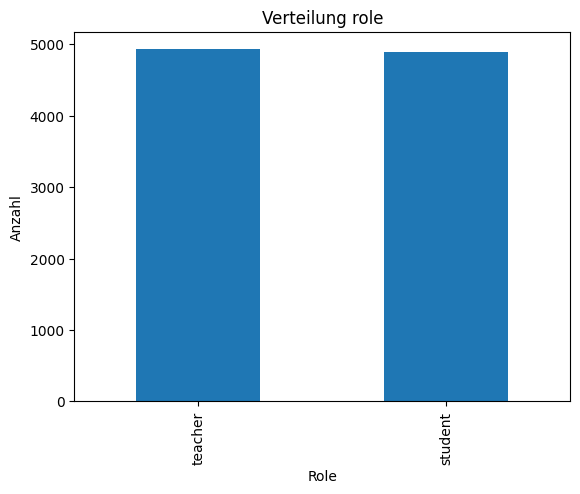

In [ ]:
# Anzahl pro role
role_counts = df_wot['role'].value_counts()
role_counts.plot(kind='bar')
plt.title('Verteilung role')
plt.xlabel('Role')
plt.ylabel('Anzahl')
plt.show()

Die besten Ergebnisse bei der Annotation für die Label in Level 1 lieferte GPT-4. Das Few-Shot-Prompting war nochmal um circa 0.02 besser, weshalb mit dieser Methode der komplette Datensatz gelabelt wird.

In [ ]:
# Prompt für Few Shot Level 1
prompt_few_level_1 = """
### CONTEXT ###
The data collected consists of conversations between a conversational assistant ('role'='teacher'), who provides guidance during a do-it-yourself project, and a user ('role'='student'), who expresses statements or questions to the conversational assistant during the process.
In order to find out which information needs the users express with this utterance (also called turn), these must be assigned to their information needs with the help of the taxonomy, i.e. annotated or classified.


### OBJECTIVE ###
Classify/annotate each statement of the user with one of the following labels, which represent an information need of the user. You are an expert in data annotation!
Each label is briefly defined for better delimitation.

The nine labels are as follows:
- "amount": Information need regarding a quantity or frequency specification.
- "material": Information need regarding the required consumables.
- "preparation": Information need regarding the steps of the process, including questions about the next step or tips that should be followed.
- "manual technique": Information need regarding a practical instruction or method on how exactly to carry out a step that has not yet been described in detail. It is about the HOW of carrying out a step.
- "instruction": Information needs regarding the selection or understanding of a project or guidance in general. Including general questions about the overall process or guidance, without referring to individual steps or detailed actions. This includes questions about the general requirements for completing a project, but without asking about specific materials, equipment or step-by-step instructions.
- "time": Information need regarding a time specification.
- "equipment": Information need regarding the required equipment such as devices, machines and tools, but not the technique of how to use them.
- "knowledge": Information need regarding background information/knowledge about the topic.
- "miscellaneous": Information need that cannot be assigned to any of the other categories/labels.

Also consider the context and the user's previous statements!
Also consider the previous statements of the conversational assistant, which can have an influence on the label of the user's information needs!


### STYLE ###
Only use the above labels.


### AUDIENCE ###
The labels are used for analysis by a group of scientists in information science and linguistics.


### RESPONSE ###
Only the label for each utterance.


### EXAMPLES ###
{few_shot_examples}
"""

### Test

In [ ]:
#für Test; nochmal kompletter Test-Datensatz
df = df.copy()
turns = df['turn'].tolist()
roles = df['role'].tolist()

In [ ]:
df_st = df[df['role'] == 'student']
df_st = df_st.copy()

In [ ]:
# Permutation mit bestem f1
best_permutation = results_permut_few_shots_df.loc[results_permut_few_shots_df['f1_score'].idxmax()]
print("Beste Reihenfolge:", best_permutation['permutation'])
print(f"Precision: {best_permutation['precision']:.3f}, Recall: {best_permutation['recall']:.3f}, F1-Score: {best_permutation['f1_score']:.3f}")

Beste Reihenfolge: ('time', 'material', 'knowledge', 'amount', 'manual technique', 'equipment', 'preparation', 'instruction', 'miscellaneous')
Precision: 0.949, Recall: 0.935, F1-Score: 0.934


In [ ]:
best_order_label = best_permutation['permutation']

best_order_few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label in best_order_label for _, row in examples[label].iterrows()])

# Platzhalter füllen
prompt_level_1 = prompt_few_level_1.replace("{few_shot_examples}", best_order_few_shot_examples)
# jetzt wieder Annotation
pred_labels_level_1 = []

turn_counts = 0
# nur die bereits gelabelten turns
turns_max = 227

for turn, role in zip(turns, roles):
  if role == 'student':
    if count < turns_max:
      label = annotate(client, model, prompt_level_1, turn)
      if label:
        print(f"Turn: {turn}\nLabel: {label}\n")
        pred_labels_level_1.append(label.lower())
      else:
        pred_labels_level_1.append("Fehler bei Anfrage")

      turn_counts += 1

    else:
      break

  else:
    # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
    continue

Turn: What are the tools and other things required for starting a bonsai tree?
Label: equipment

Turn: I'm ready for the first step now please. 
Label: preparation

Turn: I've got an idea of where I want it to grow, what's the next step that I need to take now? 
Label: preparation

Turn: How do we prepare the tree? 
Label: preparation

Turn: Ok, I have a nice dark green pot, perfect. What should I do now?
Label: preparation

Turn: Gotcha.  The tree is all ready for potting now, what's next?
Label: preparation

Turn: Ok, I've prepared the tree, wired the branches as asked and followed all direction, what should I do now?
Label: preparation

Turn: I've pruned and cleaned the roots, what's next?
Label: preparation

Turn: How do I prepare the pot?
Label: preparation

Turn: It is dry and clean, what should I do now?
Label: preparation

Turn: Okay, the tree's been potted.  What now?
Label: preparation

Turn: Thanks for the tips, is there anything else I need to know or do?
Label: instruction

In [ ]:
df_st['pred_labels_level_1'] = final_pred_labels_few_level_1

<ipython-input-113-87aff934ea48>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_st['pred_labels_level_1'] = final_pred_labels_few_level_1


In [ ]:
# Vergleich GPT Labels mit manuellen Labels
df_st['agreement_few_level_1'] = df_st['label_1'] == df_st['pred_labels_level_1']

<ipython-input-118-9008526f2197>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_st['agreement_few_level_1'] = df_st['label_1'] == df_st['pred_labels_level_1']


In [ ]:
# Labels extrahieren, true sind manuelle und pred die von gpt
pred_labels_few_level_1 = df_st['pred_labels_level_1']

In [ ]:
# Berechnung Precision, Recall und F1-Score für jedes Label
true_labels_level_1_wot = df_st['label_1']
precision = precision_score(true_labels_level_1_wot, pred_labels_few_level_1, average=None, labels=labels_level_1)
recall = recall_score(true_labels_level_1_wot, pred_labels_few_level_1, average=None, labels=labels_level_1)
f1 = f1_score(true_labels_level_1_wot, pred_labels_few_level_1, average=None, labels=labels_level_1)

In [ ]:
report = classification_report(true_labels_level_1, pred_labels_few_level_1, labels=labels_level_1)
print(report)

                  precision    recall  f1-score   support

       equipment       1.00      1.00      1.00         9
     preparation       1.00      0.99      0.99        70
        material       1.00      0.86      0.92         7
   miscellaneous       1.00      0.50      0.67         4
     instruction       0.67      0.80      0.73        10
       knowledge       0.75      1.00      0.86        12
manual technique       1.00      0.60      0.75         5
            time       1.00      1.00      1.00         3
          amount       1.00      1.00      1.00         3

        accuracy                           0.93       123
       macro avg       0.94      0.86      0.88       123
    weighted avg       0.95      0.93      0.93       123



In [ ]:
# Berechnung Cohen's Kappa
kappa = cohen_kappa_score(true_labels_level_1_wot, pred_labels_few_level_1, labels=labels_level_1)
print("Cohen's Kappa:", kappa)

# Matthews Correlation Coefficient?!
mcc = matthews_corrcoef(true_labels_level_1_wot, pred_labels_few_level_1)
print("Matthews Correlation Coefficient:", mcc)

Cohen's Kappa: 0.870376245162109
Matthews Correlation Coefficient: 0.8725963681787758


### Jetzt kompletter Datensatz

In [ ]:
turns = df_wot['turn'].tolist()
roles = df_wot['role'].tolist()

In [ ]:
# Permutation mit bestem f1
best_permutation = results_permut_few_shots_df.loc[results_permut_few_shots_df['f1_score'].idxmax()]
print("Beste Reihenfolge:", best_permutation['permutation'])
print(f"Precision: {best_permutation['precision']:.3f}, Recall: {best_permutation['recall']:.3f}, F1-Score: {best_permutation['f1_score']:.3f}")

Beste Reihenfolge: ('equipment', 'time', 'instruction', 'miscellaneous', 'amount', 'preparation', 'material', 'manual technique', 'knowledge')
Precision: 0.949, Recall: 0.935, F1-Score: 0.934


In [ ]:
# Anzahl der Turns
turn_counts = df_wot['turn'].value_counts()
print(turn_counts)

turn
Do you have any other questions?                                                                                                         4
I have included information on next step.                                                                                                4
What should I do next?                                                                                                                   3
Oh okay, so what is my next step?                                                                                                        3
What should I do after applying the paste?                                                                                               2
                                                                                                                                        ..
Next you'll learn about starting your seeds inside. I've shared the entire step for you so you'll know what to do next! Check it out.    1
Gotcha!  I started my 

In [ ]:
# Anzahl turns student
student_turns = df_wot[df_wot['role'] == 'student']['turn'].value_counts()
print(student_turns)

turn
Oh okay, so what is my next step?                                                                                             3
What should I do next?                                                                                                        3
Ask for what I can do next                                                                                                    2
What should my next step be?                                                                                                  2
How many times I need to water a plant                                                                                        2
                                                                                                                             ..
After the seeds have been dried, how should I begin planting them?                                                            1
I have washed off all the soap on the seeds. What is next?                                         

In [ ]:
best_order_label = best_permutation['permutation']

best_order_few_shot_examples = "\n".join([f" {row['turn']}\n {label}" for label in best_order_label for _, row in examples[label].iterrows()])

# Platzhalter füllen
prompt_level_1 = prompt_few_level_1.replace("{few_shot_examples}", best_order_few_shot_examples)

# turns von student/gelabelte turns werden in batches aufgeteilt -> nach jedem batch kurze Rückmeldung des Systems
batch_size_student = 500
# kompletter Datensatz wird in batches, also kleinere Teile, aufgeteilt
batch_size = 1000
# gelabelte turns sollen mitgezählt werden
counter_turn = 0
all_turns = len(turn_counts)

# jetzt wieder Annotation
pred_labels_level_1 = []

for i in range(0, all_turns, batch_size):
  batch_turns = turns[i:i + batch_size]
  batch_roles = roles[i:i + batch_size]

  for turn, role in zip(batch_turns, batch_roles):
    if role == 'student':
      label = annotate(client, model, prompt_level_1, turn)
      if label:
        #print(f"Turn: {turn}\nLabel: {label}\n")
        pred_labels_level_1.append(label.lower())
      else:
        pred_labels_level_1.append("Fehler bei Anfrage")

      # Zähler erhöhen
      counter_turn += 1

      # bei jedem 500. gelabelten Turn
      if counter_turn % batch_size_student == 0:
        print(f"{counter_turn} Turns gelabelt")

    else:
      # turns von teacher überspringen, da diese nicht gelabelt werden; nur für Kontext da
      continue

# Sobald Annotation aller turns abgeschlossen
print(f"Alle {counter_turn} turns von student gelabelt")

500 Turns gelabelt
1000 Turns gelabelt
1500 Turns gelabelt
2000 Turns gelabelt
2500 Turns gelabelt
3000 Turns gelabelt
3500 Turns gelabelt
4000 Turns gelabelt
4500 Turns gelabelt
Alle 4887 turns von student gelabelt


In [ ]:
df_wot_st = df_wot[df_wot['role'] == 'student']
df_wot_st = df_wot_st.copy()

In [ ]:
# generierte Labels als neue Spalte zu df hinzufügen
df_wot_st['pred_labels_level_1'] = pred_labels_level_1
# nach 2,5 Stunden: 2823

In [ ]:
df_wot_st.to_excel('Wizard_of_Tasks_level_1.xlsx', index=False)

In [ ]:
# Anzahl der Label Level 1
label_counts = df_wot_st['pred_labels_level_1'].value_counts()

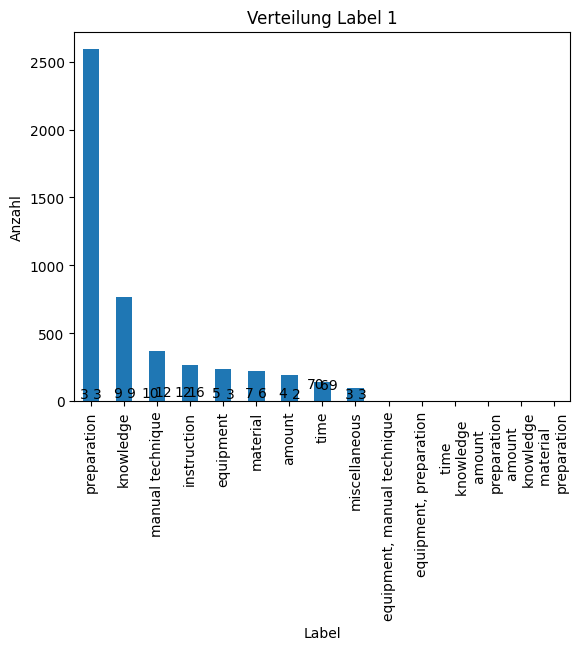

In [ ]:
# Verteilung der Labels LEvel 1
bars = label_counts.plot(kind='bar')
plt.title('Verteilung Label 1')
plt.xlabel('Label')
plt.ylabel('Anzahl')
for c in bars.containers:
  bars.bar_label(c, label_type='edge')

plt.show()

Da einige (sieben) Äußerungen leider mit zwei Kategorien gelabelt wurden, wurden diese manuell überprüft und das relevantere Informationsbedürfnis gewählt, damit der Datensatz einheitlich vorliegt und somit verarbeitet bzw. analysiert werden kann.